# <a id='toc1_'></a>[1) Cars4You ML Project Price Prediction](#toc0_)
---
**Group 2:**

- Luis Mendes 20221949
- Margarida Mourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945

**Group Member Contribution:**
- Luis Mendes:
- Margarida Mourives:
- Simon Sazonov:
- Veronica Mendes:

---

### <a id='toc1_1_1_'></a>[**Abstract**](#toc0_)

FILL at the end with the final result of 
bussines needs, integration, exploration, preparation, final model and conclution.

**Table of contents**<a id='toc0_'></a>    
- [Identifying Business Needs](#toc2_)    
- [Imports](#toc3_)    
- [Data Integration](#toc4_)    
- [Data Exploration & Initial Preprocessing](#toc5_)    
    - [Descriptive Statistics Conclusions](#toc5_1_1_)    
    - [EDA Conclusions](#toc5_1_2_)    
- [Data Preparation:](#toc6_)    
    - [Outliers and Inconsistencies](#toc6_1_1_)    
    - [Imputation:](#toc6_1_2_)    
      - [Categorical Fetures Imputation](#toc6_1_2_1_)    
      - [Encoding](#toc6_1_2_2_)    
      - [Numerical Fetures Imputation](#toc6_1_2_3_)    
      - [Conclusions: Imputation and Scaler](#toc6_1_2_4_)    
    - [Feature Selection](#toc6_1_3_)    
      - [RFE](#toc6_1_3_1_)    
      - [Decision Tree Feature Importance](#toc6_1_3_2_)    
      - [Lasso](#toc6_1_3_3_)    
      - [Conclusion Feature Selection](#toc6_1_3_4_)    
  - [Experimenting with Logarithms](#toc6_2_)    
  - [Conclusion Data Preparation](#toc6_3_)    
    - [Modeling Optimization Set](#toc6_3_1_)    
    - [Full Training Set](#toc6_3_2_)    
    - [Hold-Out Train and Validation Sets](#toc6_3_3_)    
    - [Visualizations on Preprocessed Data](#toc6_3_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Identifying Business Needs](#toc0_)

Cars 4 You is an online car resale platform that connects users looking to sell their vehicles with potential buyers across multiple brands. The company’s business model relies on an internal evaluation process in which submitted cars are physically inspected by certified mechanics to determine a fair purchase price before resale. While this approach has ensured high customer satisfaction and trust, the company’s rapid growth has resulted in longer waiting times for vehicle inspections, leading to customer attrition and loss of market share to competitors.

To address this challenge, this project aims to develop a machine learning–based predictive model capable of accurately estimating a car’s market value based solely on user-provided details, such as brand, model, year, mileage, fuel type, and condition. By leveraging historical sales and inspection data, the model will learn the underlying relationships between car attributes and their evaluated prices.

The project will begin by thoroughly exploring and understanding the dataset. This includes identifying missing values, analyzing feature distributions, and investigating potential patterns or correlations with the target variable (car price). Before modeling, the data will be carefully prepared by resolving inconsistencies, encoding categorical variables, creating new features, scaling and imputing missing values, and selecting the most important predictors for the target variable (price of cars). Throughout this entire process, is needed to ensure that the imputer, scaler, and final model are trained exclusively on the training set, without any exposure to the validation or test data, to strictly prevent data leakage.

Next, we will proceed to the modeling phase, starting with simpler algorithms to establish baseline performance. These benchmark models, such as Linear Regression, will be compared using the Mean Absolute Error (MAE) metric. MAE was chosen because it aligns with Kaggle’s evaluation standard for this competition and provides a more interpretable measure of prediction accuracy without overly penalizing outliers. Following the baseline, we will develop other models (such as K-Nearest Neighbors (KNN), Neural Networks (NN), Decision Trees (DT), etc.) and optimize their hyperparameters to try to beat this initial benchmark.

Finally, the same preprocessing steps will be applied to the test set, allowing us to evaluate the best-performing model on unseen data and generate final predictions for car prices.

The outcome of this project will enable Cars 4 You to automate the preliminary valuation process, reduce dependency on manual inspections, and deliver instant, data-driven price estimates to users. This solution will streamline operations, enhance customer experience, and provide the company with a competitive edge in the online car resale market.

# <a id='toc3_'></a>[Imports](#toc0_)

Let's import the needed libraries.

In [29]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# data partition
from sklearn.model_selection import train_test_split, KFold
# Scaling
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
# Imputation
from sklearn.impute import KNNImputer
# Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# Grid Search
from sklearn.model_selection import ParameterGrid
# Progress
from tqdm import tqdm
# CV Score
from utils import avg_scores


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

# <a id='toc4_'></a>[Data Integration](#toc0_)

This is the structure of the dataset that we are going to use.

| **Attribute**      | **Description** |
|---------------------|-----------------|
| **carID**           | Unique identifier assigned to each car. |
| **Brand**           | The car’s main brand (e.g., Ford, Toyota). |
| **model**           | The specific model of the car. |
| **year**            | The year of registration of the car. |
| **mileage**         | The total reported distance travelled by the car (in miles). |
| **tax**             | The amount of road tax (in £) applicable to the car in 2020. |
| **transmission**    | Type of transmission used by the car (e.g., Manual, Automatic, Semi-Automatic). |
| **fuelType**        | Type of fuel used by the car (e.g., Diesel, Petrol, Hybrid, Electric). |
| **mpg**             | Average miles per gallon (fuel efficiency). |
| **engineSize**      | Engine size in liters (cubic decimeters). |
| **paintQuality%**   | Mechanic’s assessment of the car’s paint quality and hull integrity (recorded during evaluation). |
| **previousOwners**  | Number of previously registered owners of the vehicle. |
| **hasDamage**       | Boolean flag provided by the seller indicating whether the car is damaged. |
| **price**           | The car’s purchase price paid by Cars 4 You (in £). |

Let's import the training dataset (the data that has labels).

In [30]:
df_cars4you_train = pd.read_csv('../project_data/train.csv')

<a class="anchor" id="2-bullet">    </a>
# <a id='toc5_'></a>[Data Exploration & Initial Preprocessing](#toc0_)

Let's see the first rows and structure of our dataset.

In [31]:
df_cars4you_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


Now, let's look at the total number of records we have, the data types, and any missing values.

In [32]:
df_cars4you_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [33]:
df_cars4you_train.isnull().sum()

carID                0
Brand             1521
model             1517
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners    1550
hasDamage         1548
dtype: int64

Let's check if the identifier for the CRA is unique (so we can set it as the index later).

In [34]:
df_cars4you_train.duplicated(subset='carID').sum()

np.int64(0)

We have information on 75,973 cars, each identified by a unique carID and a price, which serves as a distinct identifier and can be used as the dataset’s index column.

An initial exploration of the dataset revealed some formatting inconsistencies. In particular, the variables previousOwners and year should be represented as integers rather than floats. These inconsistencies will be addressed in the data-cleaning stage to ensure accurate analysis and modeling.

Additionally, several attributes contain missing values. While carID and price are complete, other variables show varying degrees of missingness. Specifically, Brand (1,521 missing, 2.00% of the total observations), model (1,517, 2.00%), year (1,491, 1.96%), transmission (1,522, 2.00%), mileage (1,463, 1.93%), fuelType (1,511, 1.99%), tax (7,904, 10.40%), mpg (7,926, 10.43%), engineSize (1,516, 2.00%), paintQuality% (1,524, 2.01%), previousOwners (1,550, 2.04%), and hasDamage (1,548, 2.04%) have missing entries.

Overall, most variables contain a relatively small proportion of missing data (around 2%), except for tax and mpg, which have over 10% missing values. These higher missing rates will require special attention during preprocessing, likely through imputation.

Another important point is that, since our goal is to build a model that operates without the assistance of a mechanic, we cannot include the variable **paintQuality%**, as it is only available after a manual inspection. Therefore, this variable will be removed from the dataset.

In [35]:
df_cars4you_train.set_index('carID', inplace=True)
df_cars4you_train.drop('paintQuality%', inplace=True ,axis=1)

Now, let's analyze some simple descriptive statistics to see if the data has any problems.

In [36]:
df_cars4you_train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


### <a id='toc5_1_1_'></a>[Descriptive Statistics Conclusions](#toc0_)

**1. Year**
- The **average manufacturing year** is approximately **2017**, with most vehicles produced between **2016 and 2019**.  
- The **minimum year (1970)** and **maximum (2024)** indicate a few **outliers or invalid entries** (e.g., future models).  
- A **low standard deviation (2.21)** shows that most cars are **recent models**.

---

**2. Price**
- The **mean price** is around **£16,882**, with prices ranging from **£450 to £159,999**.  
- The **high standard deviation (≈£9,737)** suggests **large variability** in price due to different brands, models, and specifications.  
- The **interquartile range (£10,200–£20,950)** reflects **mid-range car prices**.

---

**3. Mileage**
- The **average mileage** is **23,004 miles**, representing **lightly used cars**.  
- The **minimum value (-58,540)** is **invalid** and signals **data entry issues**.  
- Most vehicles fall between **7,423 and 32,427 miles**, which is reasonable for used vehicles.

---

**4. Tax**
- The **mean tax** is **£120.33**, and most cars are taxed between **£125 and £145**.  
- The **negative minimum (-91.12)** is **unrealistic**, indicating **erroneous records**.  
- The majority align with **standard UK vehicle tax bands**.

---

**5. MPG (Miles per Gallon)**
- The **average fuel efficiency** is **55.15 mpg**, suggesting **fuel-efficient vehicles** dominate the dataset.  
- Extreme values (from **−43.42 to 470.8 mpg**) are **outliers or errors**.  
- The middle range (46–63 mpg) appears **realistic for modern vehicles**.

---

**6. Engine Size**
- The **mean engine size** is **1.66L**, with most cars between **1.2L and 2.0L**.  
- The **minimum value (−0.10L)** is **invalid**, requiring correction.  
- A few vehicles with engines up to **6.6L** indicate the presence of **high-performance or luxury models**.

---

**7. Previous Owners**
- On average, vehicles have **about 2 previous owners**.  
- The **typical range (1–3 owners)** reflects **used cars**.  
- Negative and fractional values (e.g., **−2.35, 6.26**) are **data anomalies** that should be cleaned.

---

**8. Has Damage**
- All values are **0**, indicating **no recorded damage** for any vehicle.  
- This may mean cars are undamaged or that **damage data was not collected**, so we will remove it from the dataset.

---

However, several features (**mileage, tax, mpg, engine size, previous owners**) include **negative or implausible values**, signaling a need for **data cleaning and validation** before deeper analysis or model development.

In [37]:
df_cars4you_train.drop('hasDamage', inplace=True ,axis=1)

In [38]:
df_cars4you_train.describe(include='O').T

,count,unique,top,freq
Brand,74452,72,Ford,14808
model,74456,735,Focus,6353
transmission,74451,40,Manual,38050
fuelType,74462,34,Petrol,37995


After viewing some preliminary statistics, we see that the categorical variables have many unique labels. We'll check if this high count is genuine or if it's due to inconsistencies that need resolving.

Let's divide our variables into categorical and numerical.

In [39]:
categorical_columns = ['Brand',
                       'model',
                       'transmission',
                       'fuelType']

numerical_columns = ['year',
                     'mileage',
                     'tax',
                     'mpg',
                     'engineSize',
                     'previousOwners',
                     'price']

Now, we'll look at the unique occurrences for each categorical variable.

In [40]:
for feature in categorical_columns:
    print(f'Unique values in {feature}:')
    print(df_cars4you_train[feature].unique())
    print('-----------------------------------')

Unique values in Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']
-----------------------------------
Unique values in model:
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpo

We identified an issue with the categorical variables, as they are inconsistently formatted. To ensure that each category is properly recognized as a unique class, we will clean these variables by removing extra white spaces and converting all text to lowercase. This preprocessing step should help reduce redundancy and improve the overall data quality.

In [41]:
df_cars4you_train = df_cars4you_train.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)

Now, we'll look again at the unique occurrences for each categorical variable to see if the cleaning was effective.

In [42]:
for feature in categorical_columns:
    print(f'Unique values in {feature}:')
    print(df_cars4you_train[feature].unique())
    print('-----------------------------------')

Unique values in Brand:
['vw' 'toyota' 'audi' 'ford' 'bmw' 'skoda' 'opel' 'mercedes' 'for'
 'hyundai' 'w' 'ord' 'mw' nan 'yundai' 'bm' 'toyot' 'udi' 'ope' 'v' 'pel'
 'pe' 'mercede' 'koda' 'hyunda' 'aud' 'ercedes' 'oyota' 'skod' 'kod'
 'yunda' 'or' 'ercede' 'ud']
-----------------------------------
Unique values in model:
['golf' 'yaris' 'q2' 'fiesta' '2series' '3series' 'a3' 'octavia' 'passat'
 'focus' 'insignia' 'aclas' 'q3' 'fabia' 'aclass' 'ka+' 'glcclass' 'i30'
 'cclass' 'polo' 'eclass' 'cclas' 'q5' 'up' 'c-hr' 'mokkax' 'corsa'
 'astra' 'tt' '5series' 'aygo' '4series' 'slk' 'viva' 't-roc' 'ecosport'
 'tucson' 'ecospor' nan 'x-class' 'clclass' 'ix20' 'i20' 'rapid' 'a1'
 'auris' 'sharan' 'adam' 'x3' 'a8' 'glsclass' 'b-max' 'a4' 'kona' 'i10'
 'mokka' 's-max' 'x2' 'crosslandx' 'tiguan' 'a5' 'gleclass' 'zafira'
 'ioniq' 'a6' 'mondeo' 'yetioutdoor' 'x1' 'scala' 'sclass' '1series'
 'kamiq' 'kuga' 'tourneoconnect' 'q7' 'glaclass' 'arteon' 'slclass'
 'santafe' 'grandlandx' 'i800' 'rav4' 'to

This cleaning step actually improved the results. Next, we will group the categories of the Brand, transmission, and fuelType variables, manually as each contains only a limited number of unique values.

For the 'model', we're going to leave this variable as it is, since there are so many possible options. We'll momentarily drop it from the list of categorical variables to exclude it from the visualizations.

In [43]:
dict_brand_mapping = {'bmw' : ['bm','w','mw', 'm'],
                      'vw': ['v'],
                      'toyota': ['toyot', 'oyota', 'oyot'],
                      'audi': ['udi', 'aud', 'ud'],
                      'ford': ['ord', 'for', 'or'],
                      'skoda': ['koda', 'skod', 'kod'],
                      'opel': ['ope','pel','pe'],
                      'mercedes': ['mercede', 'ercedes', 'ercede'],
                      'hyundai': ['yundai', 'hyunda', 'yunda']}

# other category are only 5 cars, so we will say that they are null
dict_transmission_mapping = {'semi-auto':['semi-aut','emi-auto','emi-aut'],
                      'manual': ['anual','manua','anua'],
                      'NAN' : ['unknown', 'unknow', 'nknown', 'nknow', 'other'],
                      'automatic': ['automati','utomati','utomatic']}

dict_fuelType_mapping = {
    'petrol': ['etrol', 'petro', 'etro'],
    'diesel': ['iesel', 'diese', 'iese'],
    'hybrid': ['ybri', 'hybri', 'ybrid'],
    'other': ['ther', 'othe']
}

In [44]:
for keys, values in dict_brand_mapping.items():
    df_cars4you_train.loc[df_cars4you_train['Brand'].isin(values), 'Brand'] = keys

for keys, values in dict_transmission_mapping.items():
    df_cars4you_train.loc[df_cars4you_train['transmission'].isin(values), 'transmission'] = keys if keys != 'NAN' else np.nan

for keys, values in dict_fuelType_mapping.items():
    df_cars4you_train.loc[df_cars4you_train['fuelType'].isin(values), 'fuelType'] = keys

categorical_columns.pop(1) 

'model'

Now, we'll look again at the unique occurrences for each categorical variable to see if the cleaning was effective.

In [45]:
for feature in categorical_columns:
    print(f'Unique values in {feature}:')
    print(df_cars4you_train[feature].unique())
    print('-----------------------------------')

Unique values in Brand:
['vw' 'toyota' 'audi' 'ford' 'bmw' 'skoda' 'opel' 'mercedes' 'hyundai' nan]
-----------------------------------
Unique values in transmission:
['semi-auto' 'manual' 'automatic' nan]
-----------------------------------
Unique values in fuelType:
['petrol' 'diesel' 'hybrid' nan 'other' 'electric']
-----------------------------------


In [46]:
df_cars4you_train.describe(include='O').T

,count,unique,top,freq
Brand,74452,9,ford,16063
model,74456,296,focus,6775
transmission,73710,3,manual,41627
fuelType,74462,5,petrol,41181


As we can see, we now only have a limited number of unique values for brand, transmission, and fuel type—a result that makes more sense than before.

Now, we'll create some visualizations of the categorical and numerical features, and draw conclusions afterward.

Let's start by looking at the distribution of our categorical variables.

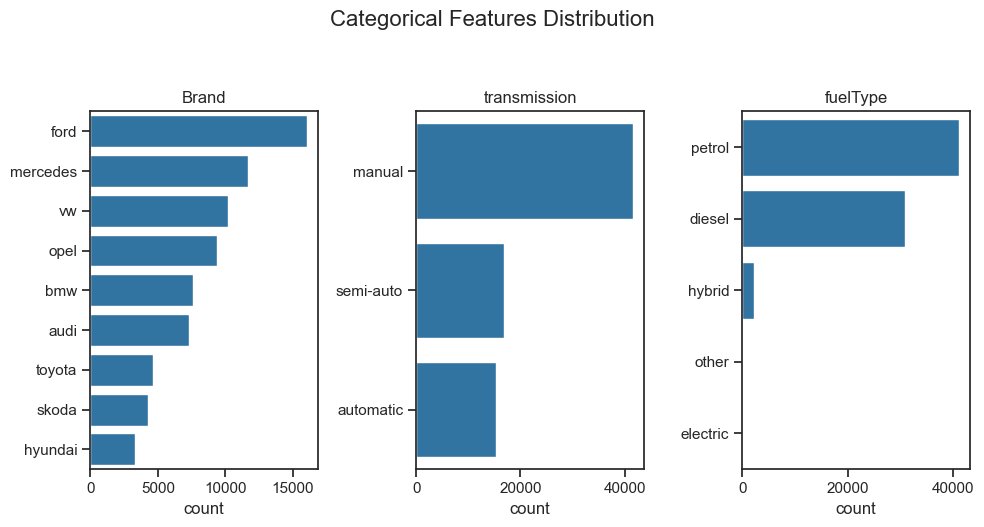

In [19]:
fig, axes= plt.subplots(1,3, figsize=(10,5))
axes = axes.flatten()
for i, column in enumerate(categorical_columns):
    order = df_cars4you_train[column].value_counts().index
    sns.countplot(y= column, data=df_cars4you_train, ax=axes[i], order=order)
    axes[i].set_title(column)
    axes[i].set_ylabel("")

plt.suptitle('Categorical Features Distribution', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

Now, let's look at the distribution of transmission and fuel type across different brands.

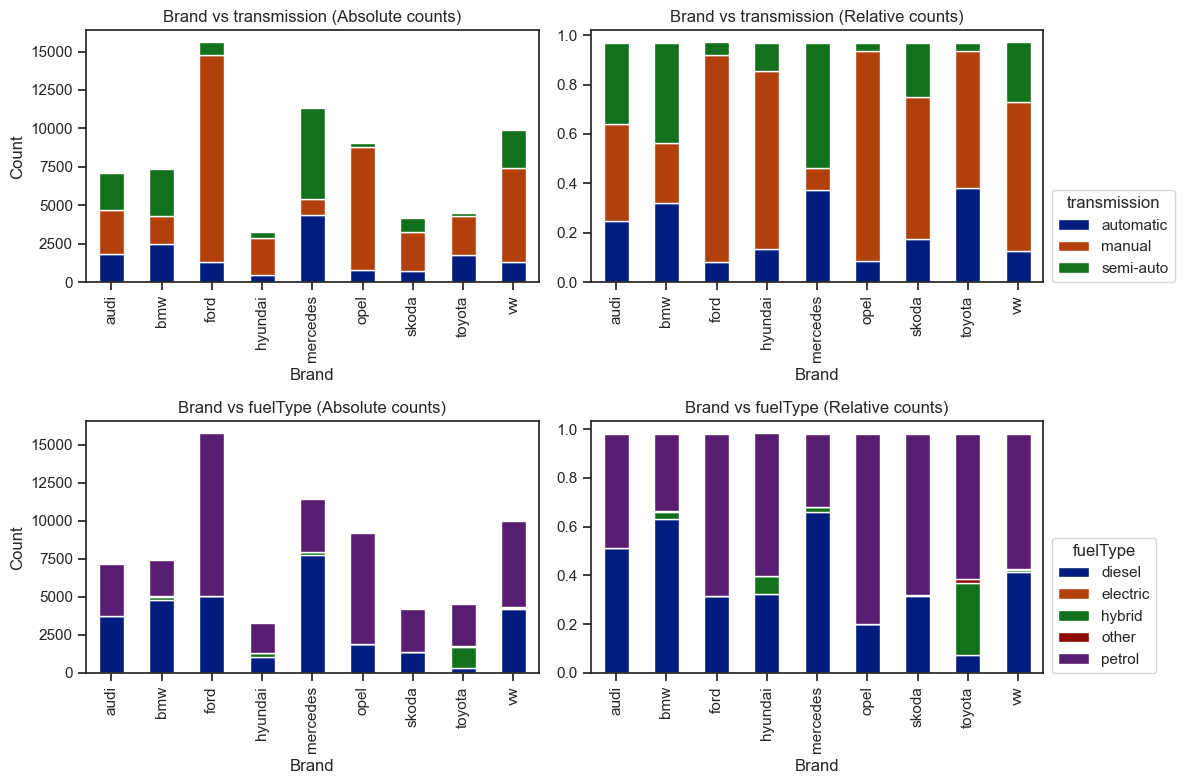

In [20]:
cat1 = 'Brand'

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

cat_list = ['transmission', 'fuelType']

for row_index in range(2):
    cat2 = cat_list[row_index]
    for column_index in range(2):

        if column_index == 0:
            catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size().unstack()
            catpc_df.plot.bar(stacked=True, ax=axes[row_index, column_index], color = sns.color_palette("dark"))
            axes[row_index, column_index].set_ylabel('Count')
            axes[row_index, column_index].legend([], frameon=False)
        
        else:
            catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size() / df_cars4you_train.groupby([cat1])[cat2].size()
            catpc_df.unstack().plot.bar(stacked=True, ax=axes[row_index, column_index], color = sns.color_palette("dark"))
            axes[row_index, column_index].legend(title=cat2, loc=(1.02, 0))
            
        axes[row_index, column_index].set_title(f'{cat1} vs {cat2} ({"Absolute" if column_index == 0 else "Relative"} counts)')
        axes[row_index, column_index].set_xlabel(cat1)
        

plt.tight_layout()
plt.show()

Now, let's look at the relationship between transmission and fuelType.

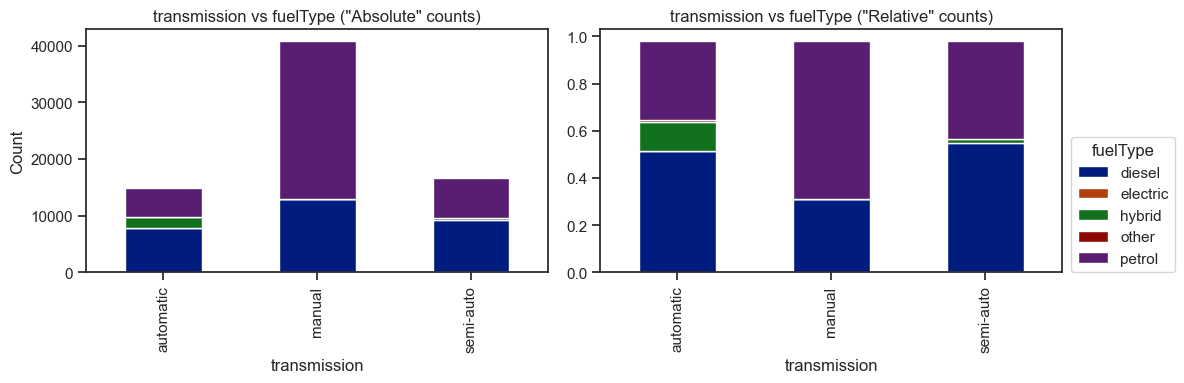

In [22]:
cat1 = 'transmission'

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cat2 = 'fuelType'

catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size().unstack()
catpc_df.plot.bar(stacked=True, ax=axes[0], color = sns.color_palette("dark"))
axes[0].set_ylabel('Count')
axes[0].legend([], frameon=False)
axes[0].set_title(f'{cat1} vs {cat2} ("Absolute" counts)')
axes[0].set_xlabel(cat1)

catpc_df = df_cars4you_train.groupby([cat1, cat2])[cat2].size() / df_cars4you_train.groupby([cat1])[cat2].size()
catpc_df.unstack().plot.bar(stacked=True, ax=axes[1], color = sns.color_palette("dark"))
axes[1].legend(title=cat2, loc=(1.02, 0))
axes[1].set_xlabel(cat1)
axes[1].set_title(f'{cat1} vs {cat2} ("Relative" counts)')

        

plt.tight_layout()
plt.show()

Now, let's examine the distribution of the numerical features.

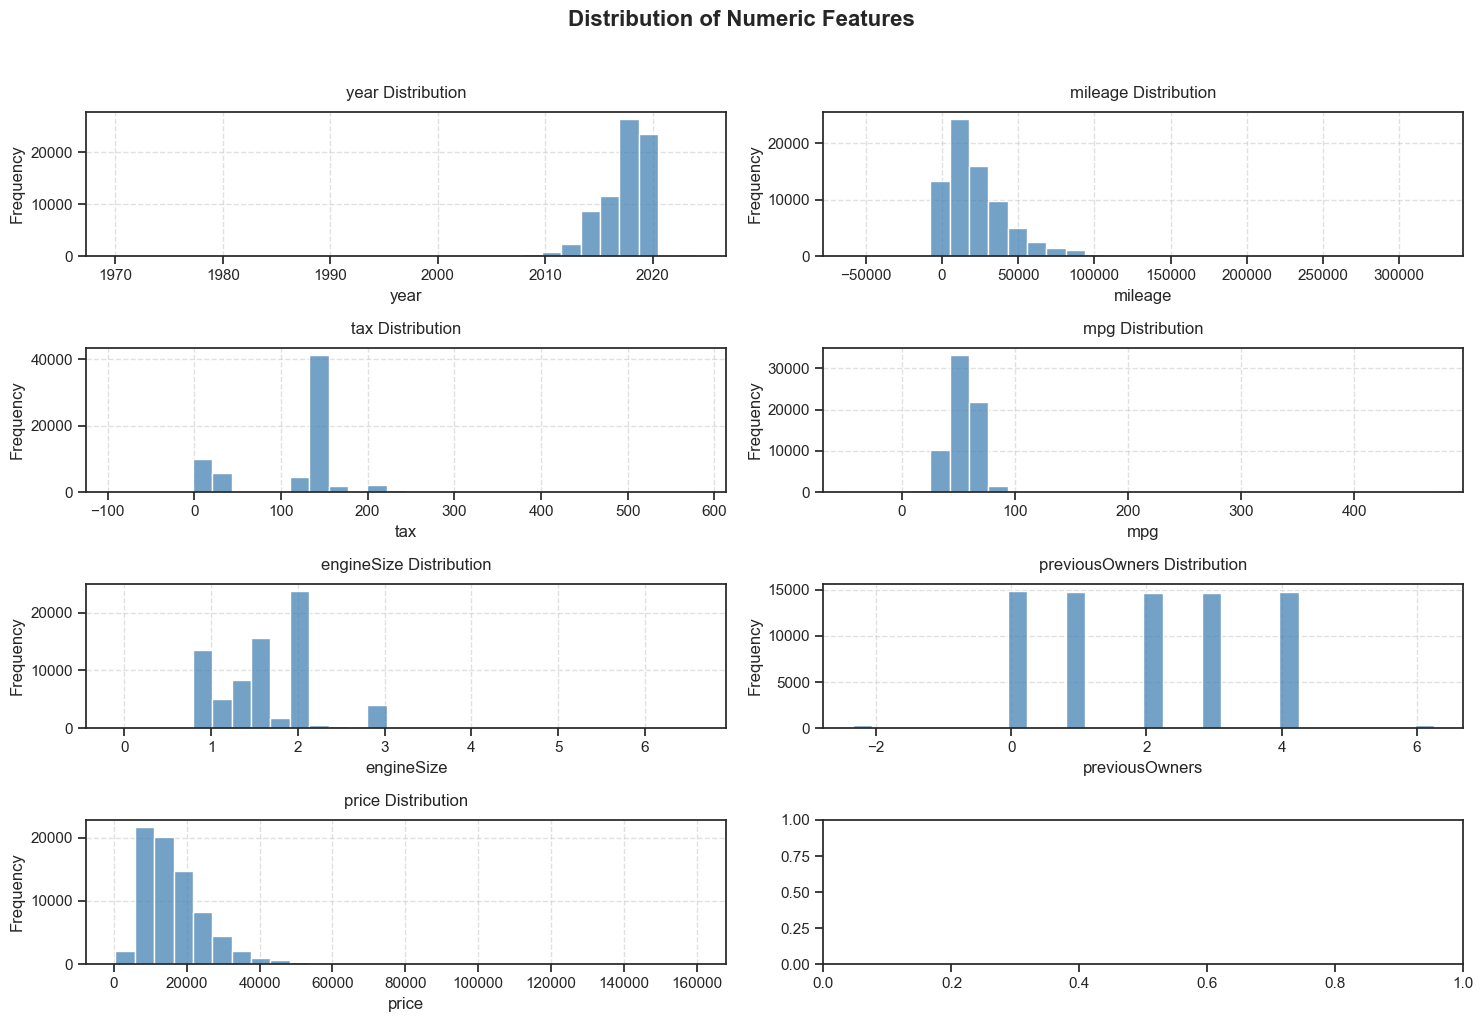

In [23]:
sp_rows = 4
sp_cols = 2

# Create the figure
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(15, 10))
axes = axes.flatten()

# --- Plot Each Feature ---
for i, feat in enumerate(numerical_columns):
    ax = axes[i]
    
    sns.histplot(df_cars4you_train[feat].dropna(), kde=False, ax=ax, bins=30, color="steelblue")
    ax.set_xlabel(feat)
    
    # Titles & formatting
    ax.set_title(f"{feat} Distribution", fontsize=12, pad=10)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.6)

# --- Layout & Global Title ---
plt.suptitle("Distribution of Numeric Features", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

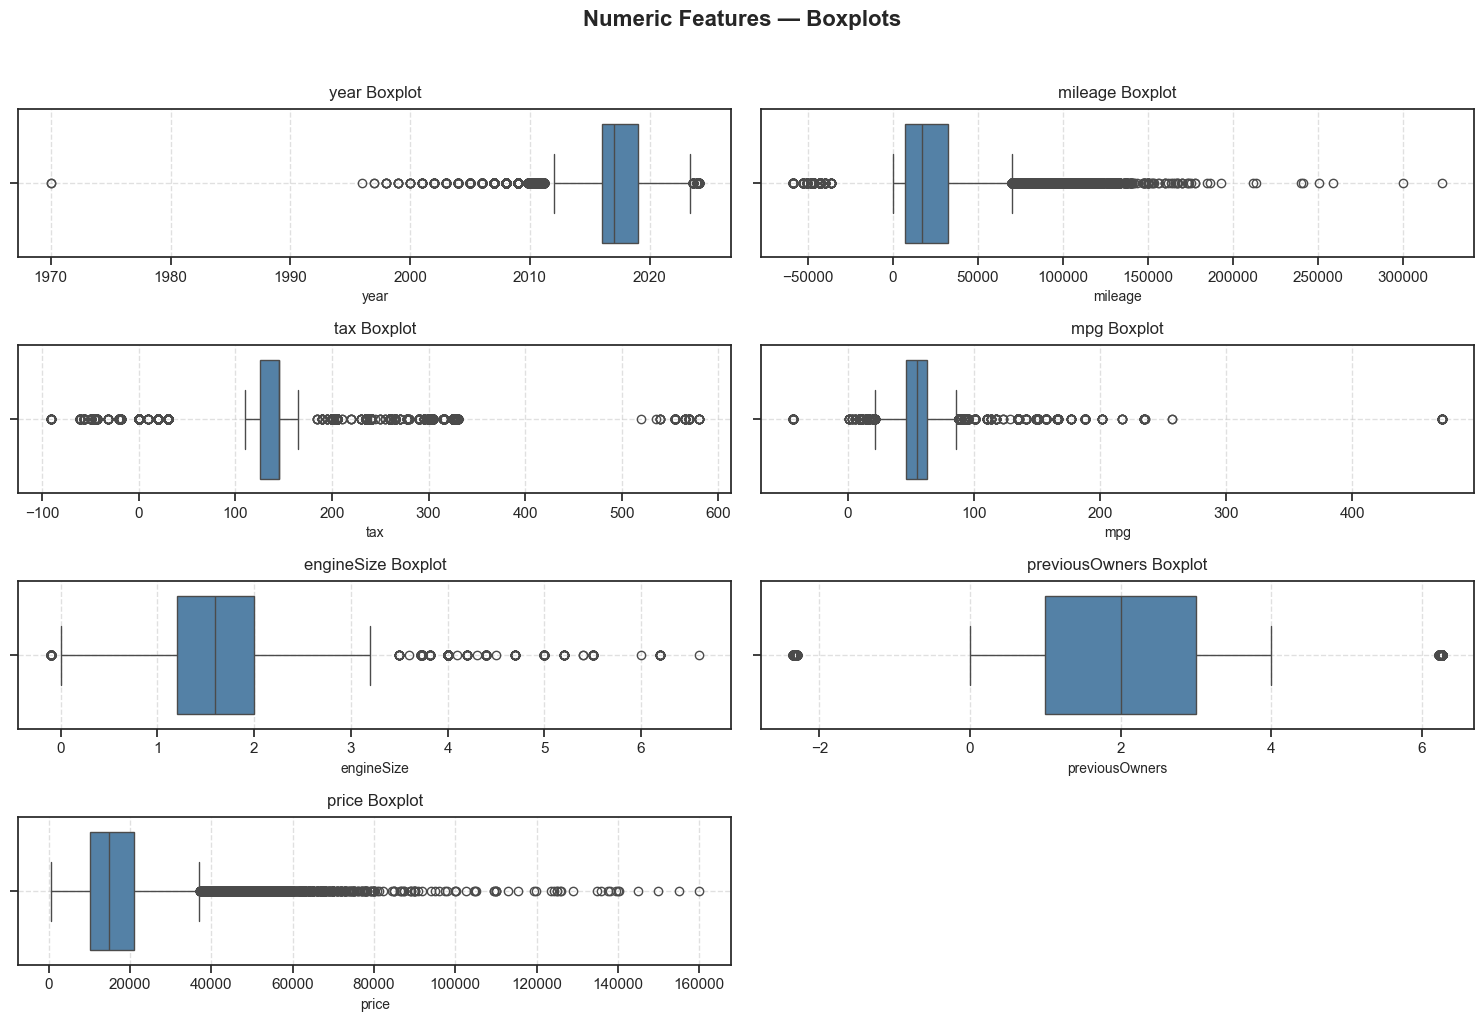

In [24]:
sp_rows = 4
sp_cols = 2

fig, axes = plt.subplots(
    sp_rows, sp_cols,
    figsize=(15, 10),
    tight_layout=True
)
axes = axes.flatten()

# --- Plot each feature ---
for i, feat in enumerate(numerical_columns):
    ax = axes[i]
    
    sns.boxplot(x=df_cars4you_train[feat].dropna(), ax=ax, color="steelblue")
    ax.set_xlabel(feat, fontsize=10)
    
    ax.set_title(f"{feat} Boxplot", fontsize=12, pad=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any empty subplots (if number of features < grid slots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numeric Features — Boxplots", fontsize=16, fontweight='bold', y=1.02)
plt.show()

Now, let's look at the correlation between our numerical features.

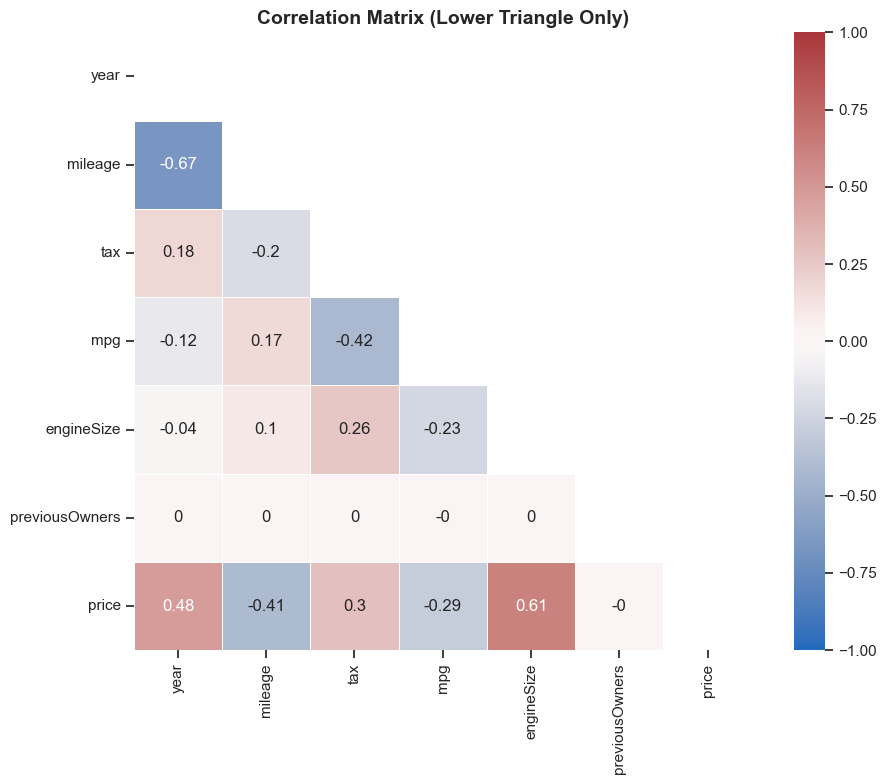

In [25]:
# Compute Pearson correlation
corr = df_cars4you_train[numerical_columns].corr(method="pearson")
# Round to 2 decimals for cleaner display
corr = corr.round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 8))

sns.heatmap(data=corr, 
            annot=True, 
            mask=mask, #aply the mask
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='vlag' # Diverging color map
            )

plt.title("Correlation Matrix (Lower Triangle Only)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

 Finally, we'll look at some pair relationships between our numerical and categorical variables.

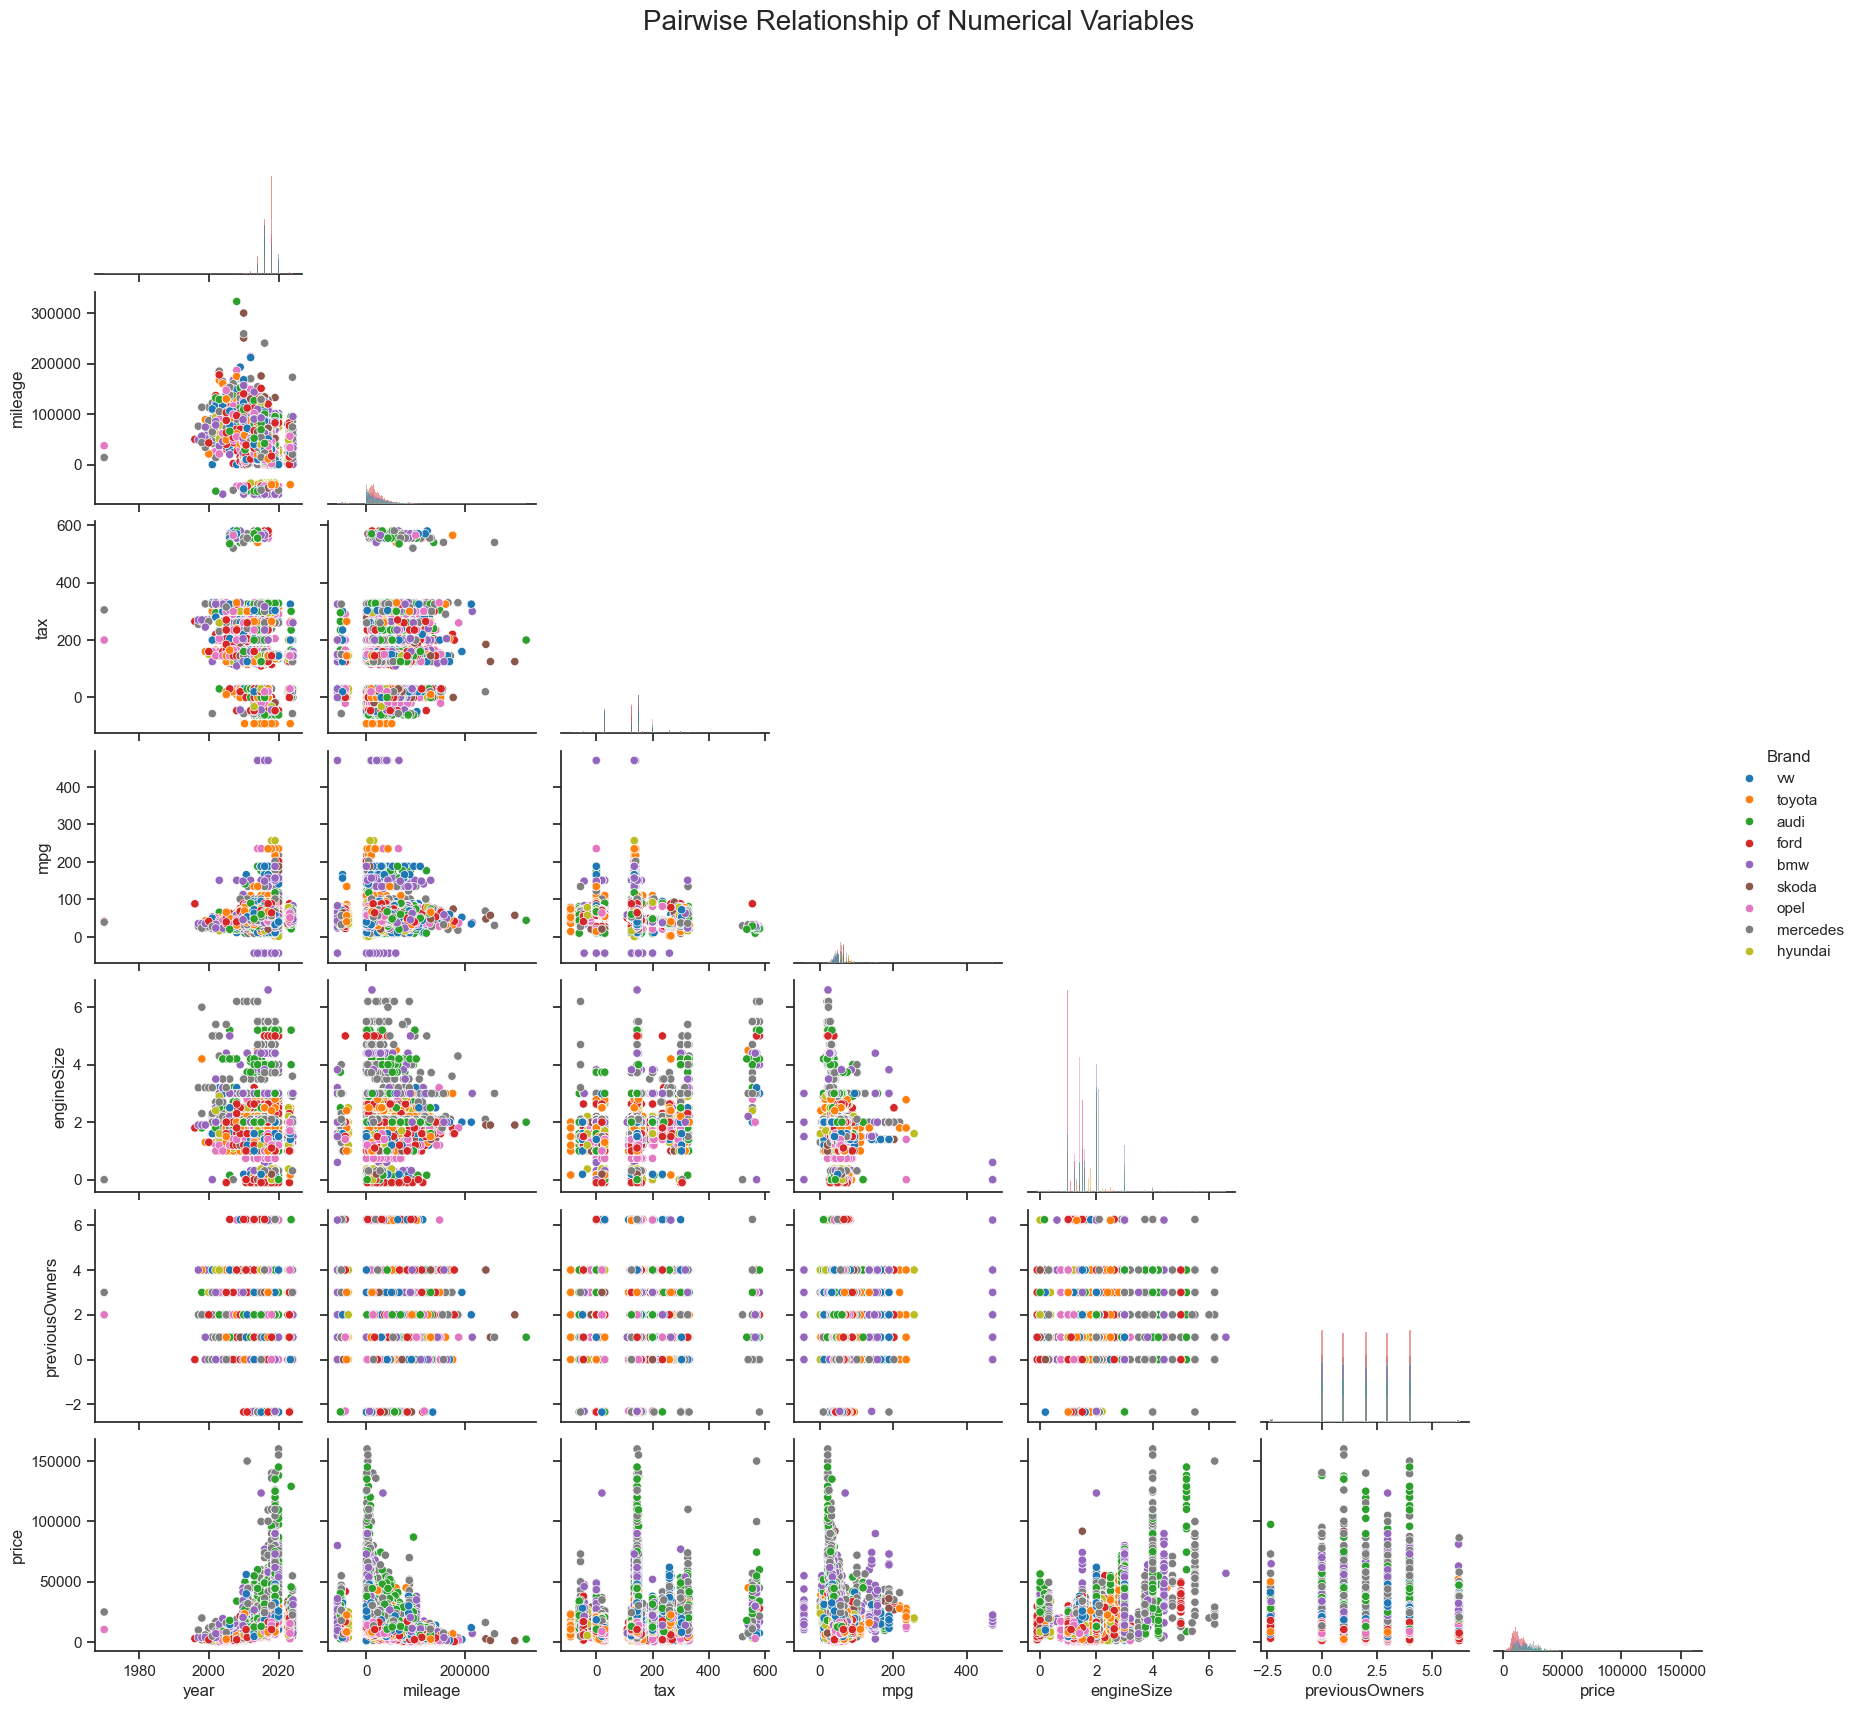

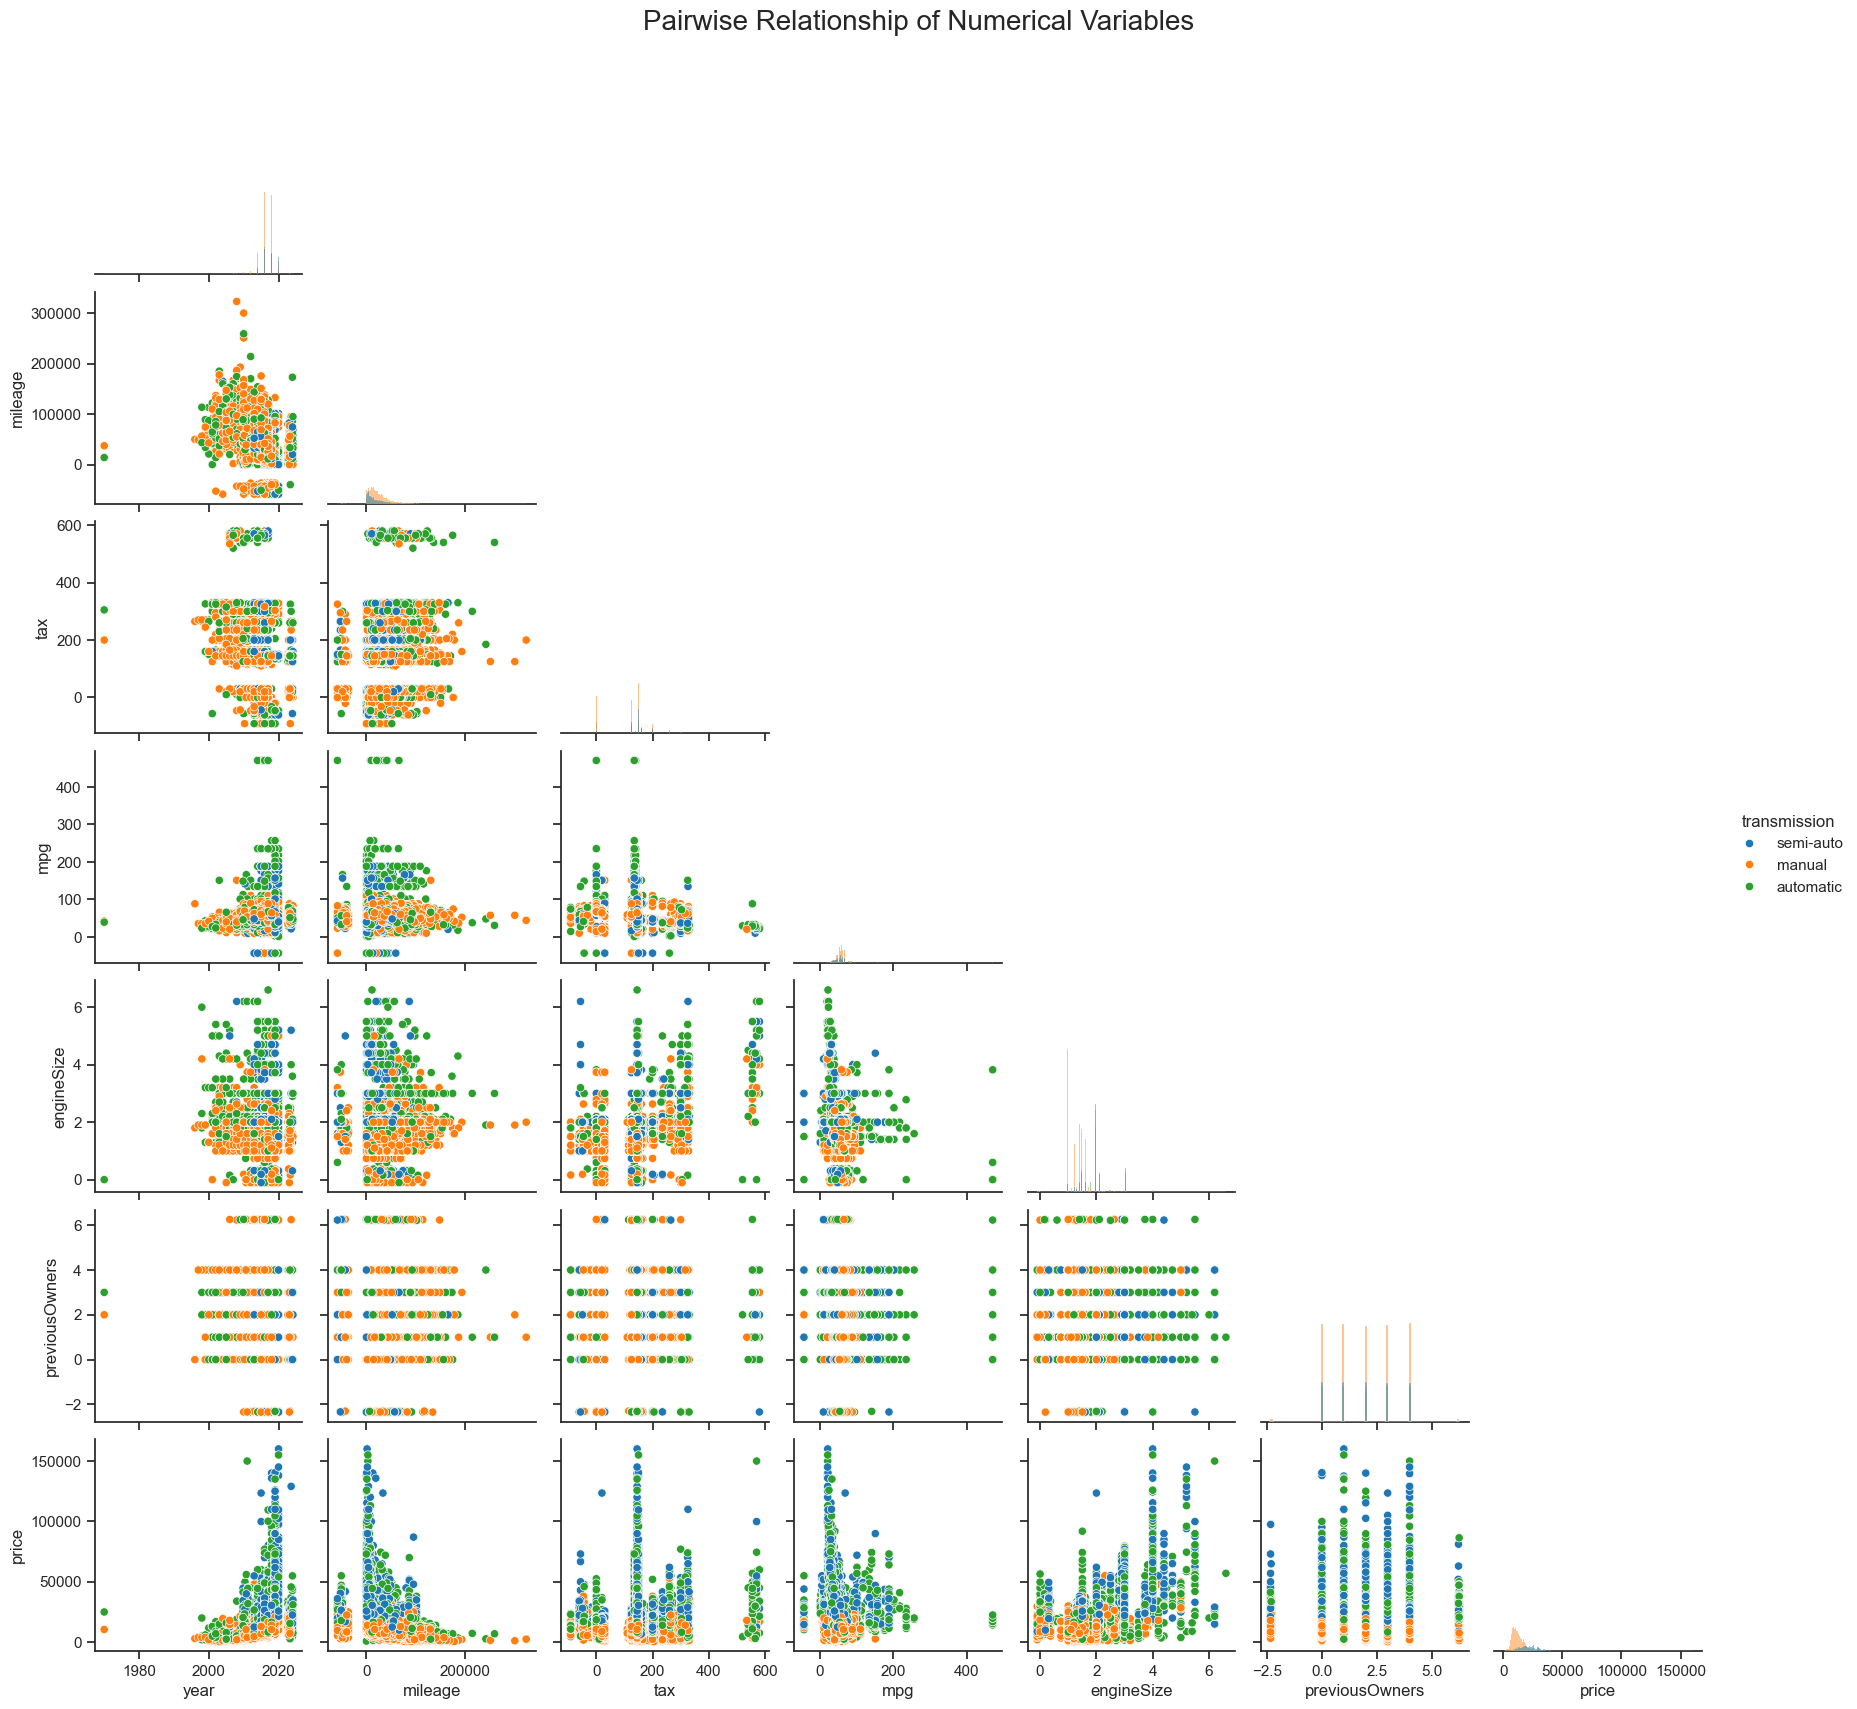

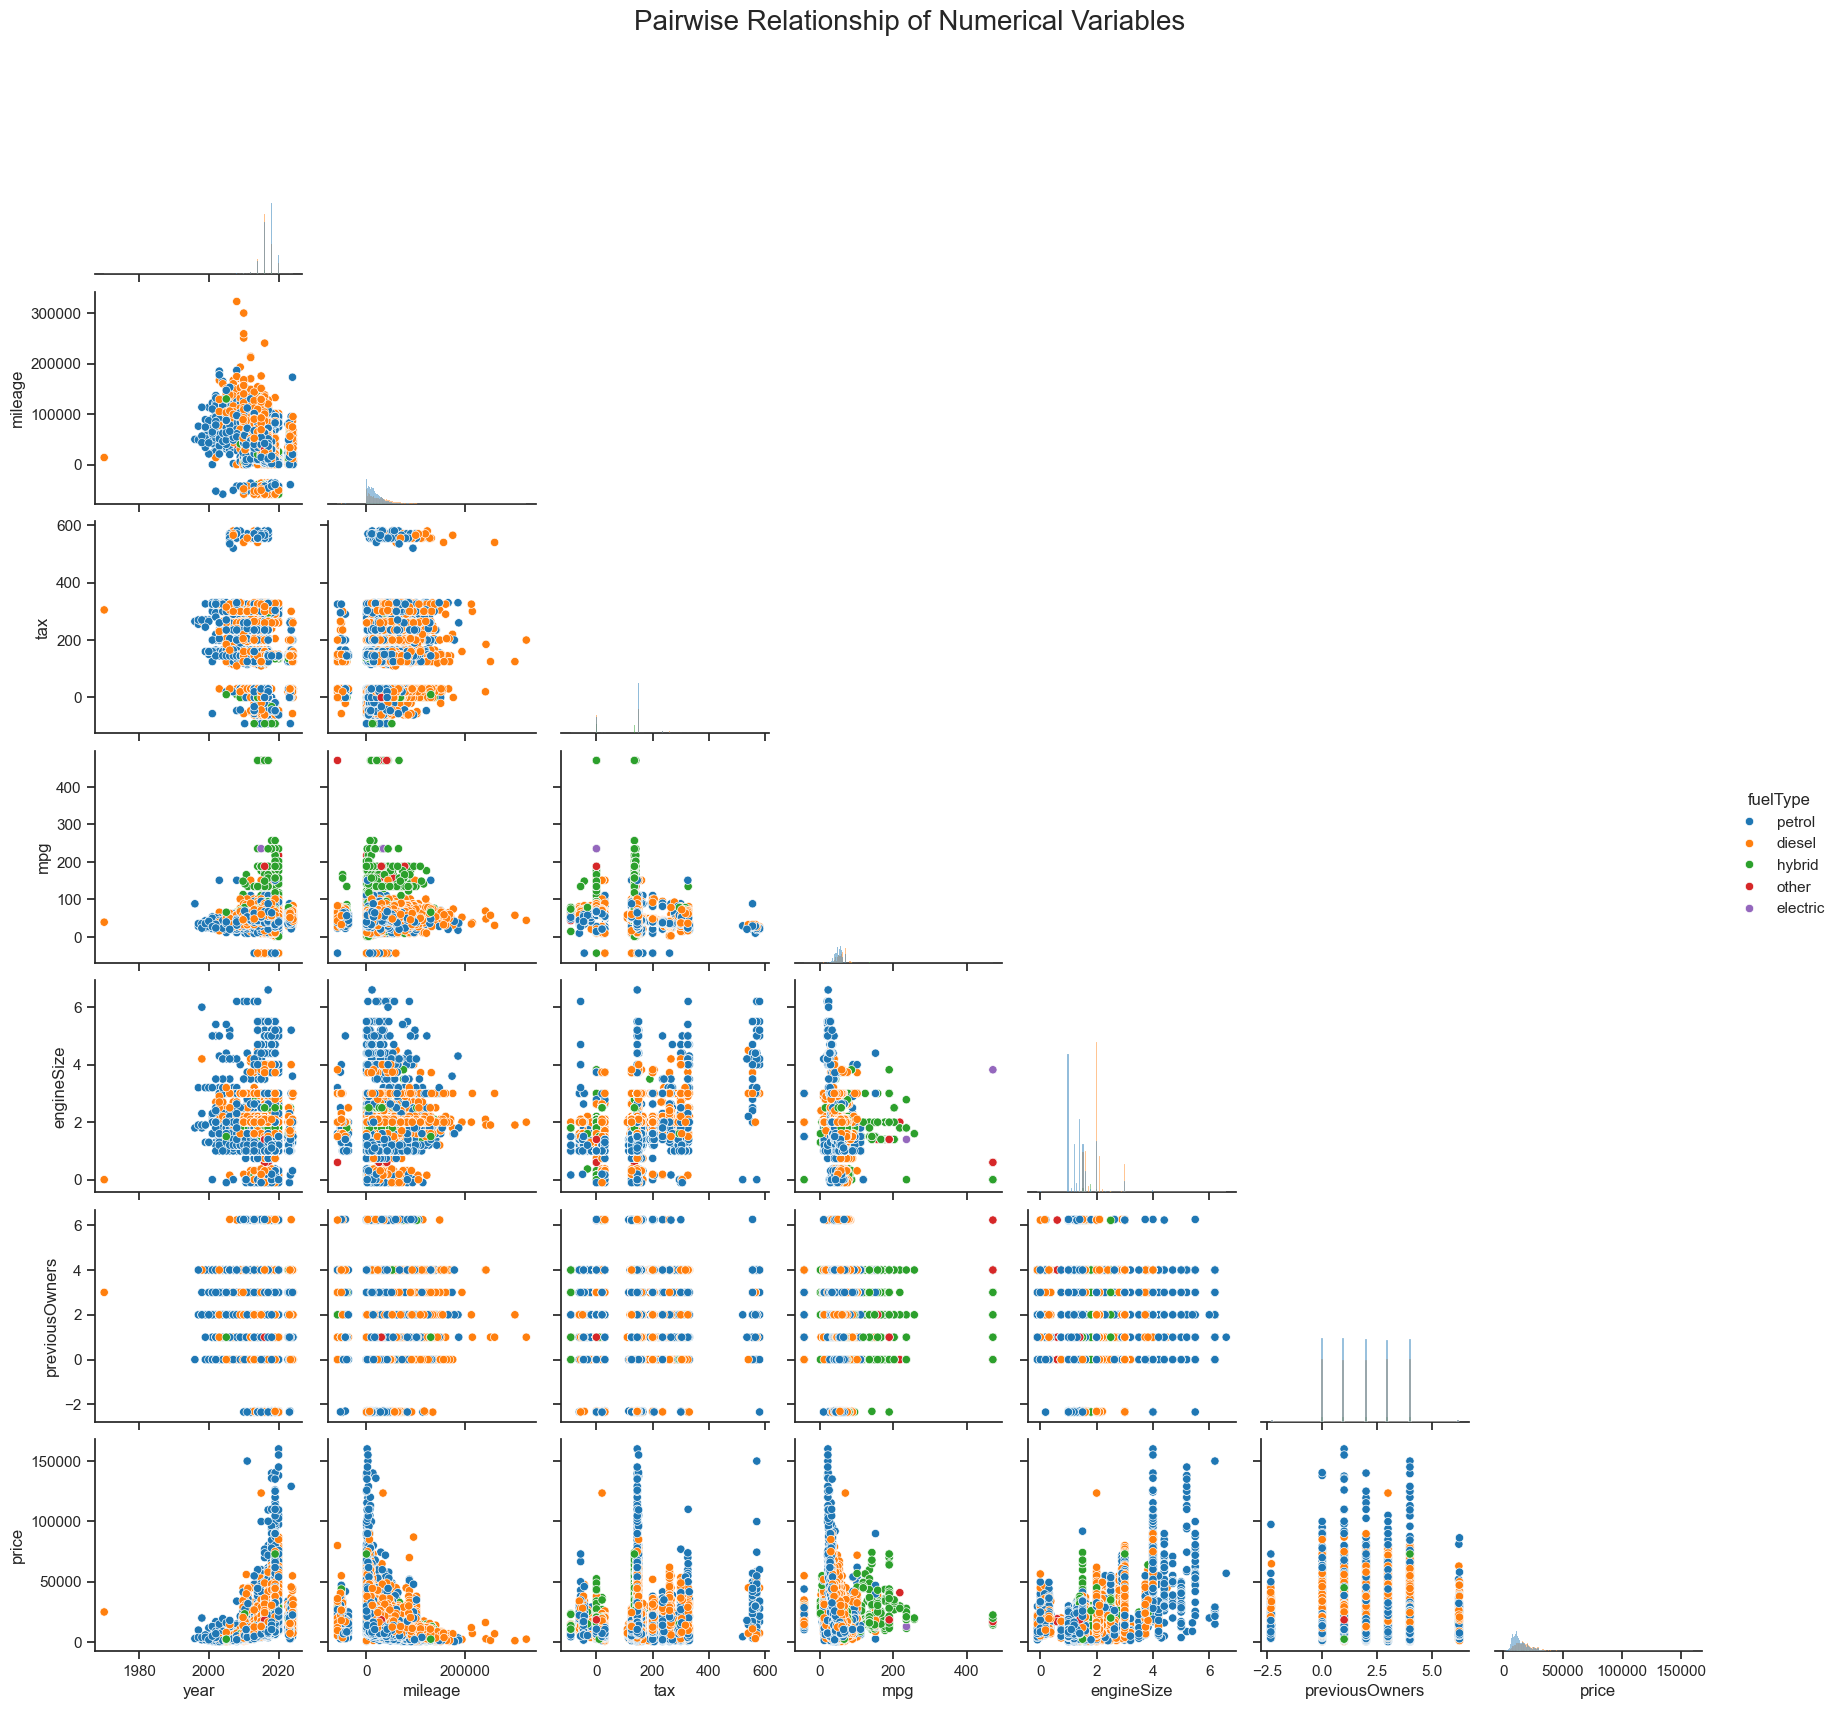

In [26]:
for categories in categorical_columns:
    sns.pairplot(
        df_cars4you_train[numerical_columns +[categories]], 
        diag_kind="hist", 
        hue= categories,
        corner=True
        )

    plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()

### <a id='toc5_1_2_'></a>[EDA Conclusions](#toc0_)

**Categorical Features**

+ **Brand:** There are 9 categories, with the most common being Ford (16,063 occurrences), followed by Mercedes, Volkswagen, Opel, BMW, Audi, Toyota, Škoda, and Hyundai. This feature has too many missing values that are difficult to impute accurately, so additional cleaning or grouping may be necessary.

+ **Model:** Contains 296 different categories. Given the large number of unique values, we will exclude this variable from modeling and visualization to avoid unnecessary complexity.

+ **Transmission:** Includes 3 categories, with manual being the most common (41,627 occurrences), followed by semi-automatic and automatic.

+ **Fuel Type:** Contains 5 categories. The most common is petrol (41,181 occurrences), followed by diesel, with smaller proportions of hybrid, electric, and other vehicles.

+ There is a clear relationship between brand, fuel type, and transmission, reflecting distinct preferences across manufacturers. Manual cars are predominantly petrol, while automatic and semi-automatic vehicles are more often diesel or hybrid, with alternative fuel types being almost exclusively automatic.

**Numerical Features**

+ **Year:** The minimum registered year is 1970, and some cars are incorrectly recorded with years after 2020. Since this dataset represents data from 2020, these unrealistic values will be removed to avoid data leakage. The distribution is left-skewed, with most cars registered in 2020.

+ **Mileage:** Some cars have negative mileage, which will be corrected. A few entries have zero mileage, likely representing new cars. The variable is right-skewed, with only a small number of cars exceeding 100,000 miles.

+ **Tax:** Several records contain negative tax values, which will be fixed. Most cars are concentrated around £140, though a few have unusually high values.

+ **MPG (Miles per Gallon):** The average fuel efficiency is around 55 mpg. Some negative and extreme outlier values are present and will need to be treated.

+ **Engine Size:** This variable contains errors as well — engine sizes below 1L are unrealistic, and a few extremely large values likely correspond to supercars or incorrect entries.

+ **Previous Owners:** The distribution appears roughly uniform, but some records have negative values, which are invalid and will be corrected.

+ **Price:** The target variable (price) shows a right-skewed distribution with several extreme high-value outliers, which is expected for car prices.

**Combination of Features**

+ No features show a strong linear correlation (absolute correlation > 0.7). However, most numerical variables exhibit some relationship with the target variable (price), except for previousOwners, which seems to have no linear impact. We will still retain this feature, as it may contribute useful interactions when combined with others. (We will make a final decision about which variables to use when we perform feature selection.).

+ Brand does not form any meaningful divisions in the numerical variables.

+ Transmission establishes distinct groups: manual cars are typically cheaper, while automatic and semi-automatic vehicles are similarly priced but generally higher than manual ones. Automatic cars also tend to have higher MPG, larger engine sizes, and higher taxes, which aligns with expectations.

+ Fuel Type further differentiates vehicles: cars with 'Other', 'Hybrid', or 'Electric' fuel types achieve the highest MPG and display similar behavior across the other features, so we should consider combining these categories into one. Finally, Petrol cars cover the widest range of prices and often have larger engine sizes.

# <a id='toc6_'></a>[Data Preparation:](#toc0_)

In this phase, we'll perform all necessary steps to prepare our data for the modeling stage. We will analyze outliers and inconsistencies, create new features, and encode our data. Additionally, we'll handle missing values for both categorical and numerical variables (and in the process, determine the best parameters for the imputer and scaler). Finally, we'll conduct feature selection using Lasso and RFE.

### <a id='toc6_1_1_'></a>[Outliers and Inconsistencies](#toc0_)

We are going to implement the following data cleaning rules:
+ **Negative Values:** Correct all negative values on mileage, tax, mpg, engineSize and previousOwners. Since our variables should not contain negative figures, we will address these inconsistencies by doing the absolute value (converting negative to positive).
+ **Engine Size:** Address incorrect engine sizes. We will treat engine sizes less than 1 (i.e., < 1) as 0.9, since an engine smaller than 1L or 0L is uncommon or impossible
+ **Year:** Remove records where the Year is greater than 2020 (i.e., > 2020), as the dataset should only contain data up to and including 2020.
+ **Convert the Year and previousOwners to integers**: since it doesn't have any sense to have float values of those variables (half of the year or half of a person), we will round it and put them as integers.

In [47]:
# Year: keep between until 2020
df_cars4you_train['year'] = df_cars4you_train['year'].round().astype('Int64')
df_cars4you_train = df_cars4you_train[~(df_cars4you_train['year'] > 2020)]

# Mileage: negatives values to positive
df_cars4you_train['mileage'] = pd.to_numeric(df_cars4you_train['mileage'], errors='coerce').abs()

# Tax: negatives values to positive
df_cars4you_train['tax'] = pd.to_numeric(df_cars4you_train['tax'], errors='coerce').abs()

# Mpg: negatives values to positive
df_cars4you_train['mpg'] = pd.to_numeric(df_cars4you_train['mpg'], errors='coerce').abs()

# Engine size: lower limit of 0.9 (minimum possible value)
df_cars4you_train['engineSize'] = pd.to_numeric(df_cars4you_train['engineSize'], errors='coerce').abs()
df_cars4you_train.loc[df_cars4you_train['engineSize'] < 0.9, 'engineSize'] = 0.9

# Previous owners: absolute values
df_cars4you_train['previousOwners'] = pd.to_numeric(df_cars4you_train['previousOwners'], errors='coerce').abs()
df_cars4you_train['previousOwners'] = df_cars4you_train['previousOwners'].round().astype('Int64')

df_cars4you_train.shape

(74124, 11)

After removing the invalid car records based on the year variable, we now have 74,124 observations, meaning that 1,849 records were deleted—approximately 2.4% of the total dataset.

Now, let's see what percentage of records we will have if we remove the extreme outliers (defined as outliers that are more than 3 times the interquartile range from the quartile boundaries in a given variable).

In [48]:
q1 = df_cars4you_train[numerical_columns].quantile(0.25)
q3 = df_cars4you_train[numerical_columns].quantile(0.75)
iqr = q3 - q1
lower_lim = q1 - (iqr * 3)
upper_lim = q3 + (iqr * 3)

filters_iqr_all = df_cars4you_train[numerical_columns[:-1]].apply(
    lambda col: col.between(lower_lim[col.name], upper_lim[col.name], inclusive='neither')
).all(axis=1)


df_cars4you_NO_outliers = df_cars4you_train[filters_iqr_all]

print('Percentage of data kept after removing outliers:', 100*(np.round(df_cars4you_NO_outliers.shape[0] / df_cars4you_train.shape[0], 4)))

Percentage of data kept after removing outliers: 60.6


We will not remove any outliers because doing so would result in the loss of too many records (almost 40%). We will assume their presence is 'normal' for this dataset.

Let's see how our dataset looks up to this point.

In [49]:
df_cars4you_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74124 entries, 69512 to 15795
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           72645 non-null  object 
 1   model           72649 non-null  object 
 2   year            74124 non-null  Int64  
 3   price           74124 non-null  int64  
 4   transmission    71906 non-null  object 
 5   mileage         72688 non-null  float64
 6   fuelType        72654 non-null  object 
 7   tax             66421 non-null  float64
 8   mpg             66397 non-null  float64
 9   engineSize      72637 non-null  float64
 10  previousOwners  72612 non-null  Int64  
dtypes: Int64(2), float64(4), int64(1), object(4)
memory usage: 6.9+ MB


After removing the invalid car records based on the year variable, we now have 74,124 observations, meaning that 1,849 records were deleted—approximately 2.4% of the total dataset. Additionally, the year and previousOwners variables are now registered as integers. Since we still have missing values in the dataset, we will handle them in the following section.

### <a id='toc6_1_2_'></a>[Imputation:](#toc0_)

We will need to impute missing values for the following variables:

+ Categorical: transmission, fuelType.

+ Numeric: mileage, tax, mpg, engineSize, previousOwners.

#### <a id='toc6_1_2_1_'></a>[Categorical Fetures Imputation](#toc0_)

For categorical features, we used mode imputation, as it is a simple and reliable method that preserves the variable's distribution, since we don't have a large number of missing values in these features.

We can use the mode before splitting because if we split the data randomly, the mode of our training set should be the same as the mode of the entire dataset.

In [50]:
#filling with mode

#store mode of training data in a variable
mode_to_fill_transmission = df_cars4you_train['transmission'].mode()[0]
mode_to_fill_fueltype = df_cars4you_train['fuelType'].mode()[0]

# fill on df_cars4you_train
df_cars4you_train['transmission'].fillna(mode_to_fill_transmission, inplace=True)
df_cars4you_train['fuelType'].fillna(mode_to_fill_fueltype, inplace=True)

Let's analyze the relationship between the brand and the model.

In [51]:
df_complete = df_cars4you_train.dropna(subset=['Brand', 'model'])

# Now, we group by 'model' and count the number of unique 'brands' for each
model_to_brand_counts = df_complete.groupby('model')['Brand'].nunique()

# Get a list of any models that map to MORE than one brand
inconsistent_models = model_to_brand_counts[model_to_brand_counts > 1]

inconsistent_models

model
amarok        2
arteon        2
caddymaxi     2
california    2
caravelle     2
cc            2
gol           2
golf          2
golfsv        2
i3            2
passat        2
polo          2
scirocco      2
sharan        2
shuttle       2
t-cros        2
t-cross       2
t-roc         2
tiguan        2
touareg       2
touran        2
u             2
up            2
Name: Brand, dtype: int64

In [52]:
df_cars4you_train.groupby('Brand')['model'].nunique()

Brand
audi        29
bmw         58
ford        36
hyundai     24
mercedes    41
opel        34
skoda       24
toyota      28
vw          45
Name: model, dtype: int64

We draw two conclusions from the analysis:

+ We have more than one models per brand and many models overall, so we will not use the car model variable.

+ Since we have only a few rows with missing brand values (1,479 records), we will drop these missing records. We could then use the car brand later to create one model per brand, if we decide to. However, for the 'generic model,' we will not use the brand variable because it has too many categories to encode effectively.

In [53]:
df_cars4you_train.drop(['model'], axis=1, inplace= True)
df_cars4you_train.dropna(subset=['Brand'], inplace = True)

Let's see how our data looks at this moment.

In [54]:
df_cars4you_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72645 entries, 69512 to 15795
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           72645 non-null  object 
 1   year            72645 non-null  Int64  
 2   price           72645 non-null  int64  
 3   transmission    72645 non-null  object 
 4   mileage         71233 non-null  float64
 5   fuelType        72645 non-null  object 
 6   tax             65106 non-null  float64
 7   mpg             65080 non-null  float64
 8   engineSize      71192 non-null  float64
 9   previousOwners  71160 non-null  Int64  
dtypes: Int64(2), float64(4), int64(1), object(3)
memory usage: 6.2+ MB


Let's calculate the total number of deleted rows.

In [55]:
(75973 - 72645) * 100 / 75973
# number of rows removed

4.380503599963145

And now, let's see the total number of missing values at this moment.

In [56]:
df_cars4you_train.isnull().sum()

Brand                0
year                 0
price                0
transmission         0
mileage           1412
fuelType             0
tax               7539
mpg               7565
engineSize        1453
previousOwners    1485
dtype: int64

We can conclude that until this point: 
+ We have deleted on total 4.38% that are 3328 observations.

+ Brand, year, price, and transmission currently have no missing values (0).

+ PreviousOwners has 1,485 missing records.

+ EngineSize has 1,453 missing records.

+ Mileage has 1,412 missing records.

+ MPG (miles per gallon) and tax have the largest number of missing records, with 7,565 and 7,539, respectively.

Since these missing values represent a significant portion of the data and we have already deleted many rows, we are going to resolve them through imputation.

#### <a id='toc6_1_2_2_'></a>[Encoding](#toc0_)

We need to encode the categorical variables and we will perform some feature engineering to create more meaningful variables. Specifically, we will:

+ **Simplify fuelType into three categories:** petrol, diesel, and other. The 'other' category will combine hybrid, electric, and any remaining fuel types, as their behavior is similar. These categories will then be one-hot encoded using n-1 dummy variables to avoid multicollinearity.

+ **Encode transmission** as dummy variables using n–1 categories.

+ **Change the years, to Years_old:** We will calculate the age of the car using the 'Actual Year.' Since the original price data is from 2020, we will use 2021 as the 'Actual Year' for our training data, assuming the data was acquired after the end of 2020. However, for our test set, we will use our current year, 2025 (the year we are developing the model), assuming the test data originates from this year, to reflect current conditions.

In [57]:
df_cars4you_train_encoded = df_cars4you_train.copy()

# Years_old
df_cars4you_train_encoded['Years_old'] = 2021 - df_cars4you_train_encoded['year']
df_cars4you_train_encoded.drop('year', inplace = True, axis = 1)

# Only 3 options on fueltype: petrol, diesel and other
df_cars4you_train_encoded.loc[df_cars4you_train_encoded['fuelType'].isin(['electric', 'hybrid']), 'fuelType'] = 'other'

# Dummies for categorical variables
df_cars4you_train_encoded = pd.get_dummies(df_cars4you_train_encoded, columns=['transmission', 'fuelType'], drop_first=True, dtype= int)
dummy_columns_train = df_cars4you_train_encoded.columns

In [58]:
df_cars4you_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72645 entries, 69512 to 15795
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   72645 non-null  object 
 1   price                   72645 non-null  int64  
 2   mileage                 71233 non-null  float64
 3   tax                     65106 non-null  float64
 4   mpg                     65080 non-null  float64
 5   engineSize              71192 non-null  float64
 6   previousOwners          71160 non-null  Int64  
 7   Years_old               72645 non-null  Int64  
 8   transmission_manual     72645 non-null  int64  
 9   transmission_semi-auto  72645 non-null  int64  
 10  fuelType_other          72645 non-null  int64  
 11  fuelType_petrol         72645 non-null  int64  
dtypes: Int64(2), float64(4), int64(5), object(1)
memory usage: 7.3+ MB


Dummy features are created as follows:
+ **Transmission:** We created dummy variables for Manual and Semi-Auto. When both of these variables are 0, the transmission type is inferred to be Automatic.
+ **FuelType:** We created dummy variables for Other and Petrol. When both of these variables are 0, the fuel type is inferred to be Diesel.

#### <a id='toc6_1_2_3_'></a>[Numerical Fetures Imputation](#toc0_)

Next, we'll perform imputation for the numerical features.

We have chosen to use an advanced imputation method, such as K-Nearest Neighbors (KNN) Imputer , because we believe the missing values in these numerical variables are likely related to and similar to other observations in the dataset. 

This approach is superior to simple imputation methods, especially since the numerical features collectively contained the highest percentage of missing values in our dataset. Using KNN helps preserve the underlying data distribution by filling the gaps with values calculated from similar neighboring records, rather than distorting the data with a single constant value.

Before doing so, we will scale the values (trying different scalers: MinMax (to the 0 to 1 and -1 to 1 ranges), Robust Scaler, and Standard Scaler), as the K-Nearest Neighbors (KNN) Imputer relies on distances to find the nearest neighbors. Scaling ensures that all features contribute equally when identifying the most similar observations to fill the missing values.

We will test the best parameters for our K-Nearest Neighbors (KNN) Imputer. Specifically, we will evaluate the number of neighbors (n_neighbors) from 7 to 11 and test the two possible weight types: uniform and distance-weighted.

We will then assess the imputation performance using 3 different types of predictive models: Linear Regression, K-Nearest Neighbors (KNN), and Decision Trees. The results from each model will be aggregated and generalized to conclude the best overall imputation parameters and scalers.

To test the scalers and imputer hyperparameters, we'll use cross-validation (specifically, we'll divide the data into 5 folds). We will then aggregate the results of each fold using the mean and variance to understand how each solution performs and choose the best one. The selection criteria will prioritize the model with the lowest Mean Absolute Error (MAE) on the validation sets. Additionally, we will evaluate overfitting (lower is better) and the variance of the MAE across both the training and standard deviation sets (lower is better).

In [59]:
cv_method = KFold(n_splits= 5, random_state = 22, shuffle= True)

X_encoded = df_cars4you_train_encoded.drop(['Brand','price'], axis=1)
Y = df_cars4you_train_encoded['price']

Now, let's define the hyperparameter search space for the number of neighbors, distance metric, and scaler, and create dictionaries to store the results.

In [39]:
# Define the parameters to test
param_grid = {'n_neighbors': list(range(7, 12)),
              'distance': ['uniform', 'distance'],
              'scalar': [RobustScaler(), MinMaxScaler(), MinMaxScaler(feature_range = (-1,1)), StandardScaler()]}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_imputer = {}
dic_val_score_imputer = {}

Next, we will run all defined parameters using cross-validation (CV) on a Linear Regression model (using its default hyperparameters).

In [ ]:
# aprox 6min, total 4h
for params in tqdm(grid):
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors=params['n_neighbors'], weights=params['distance']),
               scalar = params['scalar'],
               model = LinearRegression(),
               score_train_dic = dic_train_score_imputer,
               score_val_dic = dic_val_score_imputer,
               dic_key = ('LR', str(params['scalar']) ,str(params['n_neighbors']), params['distance']))


5it [11:40, 140.12s/it]00:00<?, ?it/s]
5it [06:52, 82.53s/it][11:40<7:35:23, 700.61s/it]
5it [07:05, 85.02s/it][18:33<5:36:27, 531.25s/it]
5it [06:38, 79.75s/it][25:38<4:57:43, 482.79s/it]
5it [08:16, 99.25s/it][32:17<4:29:46, 449.62s/it]
5it [06:19, 75.84s/it][40:33<4:32:05, 466.45s/it]
5it [06:23, 76.73s/it][46:52<4:07:30, 436.79s/it]
5it [05:50, 70.07s/it][53:16<3:50:41, 419.43s/it]
5it [06:45, 81.15s/it][59:06<3:31:58, 397.45s/it]
5it [05:49, 69.94s/it][1:05:52<3:26:41, 400.05s/it]
5it [05:48, 69.77s/it] [1:11:42<3:12:15, 384.51s/it]
5it [06:43, 80.72s/it] [1:17:31<3:00:34, 373.61s/it]
5it [05:12, 62.45s/it] [1:24:14<2:58:36, 382.73s/it]
5it [06:39, 79.90s/it] [1:29:27<2:42:37, 361.39s/it]
5it [05:28, 65.73s/it] [1:36:06<2:41:35, 372.91s/it]
5it [05:13, 62.66s/it] [1:41:35<2:29:49, 359.57s/it]
5it [05:19, 63.96s/it] [1:46:48<2:18:15, 345.64s/it]
5it [05:20, 64.10s/it] [1:52:08<2:09:31, 337.87s/it]
5it [05:22, 64.50s/it] [1:57:28<2:01:58, 332.66s/it]
5it [05:21, 64.30s/it] [2:02:51<

We will now perform the same cross-validation process, but using a K-Nearest Neighbors (KNN) model with uniform weights and 8 neighbors (which is higher than the default of 5, to reduce the influence of noisy points).

In [42]:
for params in tqdm(grid):
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors=params['n_neighbors'], weights=params['distance']),
               scalar = params['scalar'],
               model = KNeighborsRegressor(n_neighbors=8, weights='uniform', n_jobs=-1),
               score_train_dic = dic_train_score_imputer,
               score_val_dic = dic_val_score_imputer,
               dic_key = ('KNN', str(params['scalar']) ,str(params['n_neighbors']), params['distance']))


5it [05:48, 69.75s/it][00:00<?, ?it/s]
5it [06:00, 72.17s/it][05:48<3:46:41, 348.75s/it]
5it [06:05, 73.13s/it][11:49<3:45:22, 355.86s/it]
5it [06:13, 74.65s/it][17:55<3:42:12, 360.35s/it]
5it [06:23, 76.78s/it][24:08<3:39:15, 365.44s/it]
5it [06:29, 77.97s/it][30:32<3:37:03, 372.11s/it]
5it [06:38, 79.63s/it][37:02<3:34:16, 378.14s/it]
5it [06:31, 78.29s/it][43:40<3:31:34, 384.68s/it]
5it [06:06, 73.36s/it][50:11<3:26:18, 386.84s/it]
5it [05:58, 71.66s/it][56:18<3:16:37, 380.57s/it]
5it [05:48, 69.66s/it] [1:02:17<3:06:51, 373.70s/it]
5it [05:44, 68.99s/it] [1:08:05<2:56:51, 365.93s/it]
5it [05:42, 68.48s/it] [1:13:50<2:47:47, 359.55s/it]
5it [05:47, 69.48s/it] [1:19:32<2:39:27, 354.37s/it]
5it [05:54, 70.94s/it] [1:25:20<2:32:39, 352.27s/it]
5it [05:58, 71.79s/it] [1:31:14<2:27:05, 353.02s/it]
5it [05:43, 68.77s/it] [1:37:13<2:21:55, 354.81s/it]
5it [05:54, 70.89s/it] [1:42:57<2:14:44, 351.52s/it]
5it [05:50, 70.14s/it] [1:48:52<2:09:13, 352.41s/it]
5it [05:51, 70.37s/it] [1:54:42<2:

Finally, we will test the model using a Decision Tree. As a criterion, we are going to use the Absolute Error, which is the same as Mean Absolute Error (MAE) since that is the metric we want to optimize. We will pre-prune the tree to reduce overfitting by setting a maximum depth of 7 and a minimum of 500 samples required to split a node.

In [43]:
for params in tqdm(grid):
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors=params['n_neighbors'], weights=params['distance']),
               scalar = params['scalar'],
               model = DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_split=500),
               score_train_dic = dic_train_score_imputer,
               score_val_dic = dic_val_score_imputer,
               dic_key = ('DT', str(params['scalar']) ,str(params['n_neighbors']), params['distance']))


5it [15:06, 181.36s/it]00:00<?, ?it/s]
5it [15:02, 180.59s/it]15:06<9:49:26, 906.84s/it]
5it [15:00, 180.10s/it]30:09<9:32:53, 904.55s/it]
5it [15:16, 183.30s/it]45:10<9:16:40, 902.72s/it]
5it [15:04, 180.80s/it]1:00:26<9:04:53, 908.16s/it]
5it [17:07, 205.45s/it]1:15:30<8:48:53, 906.67s/it]
5it [17:57, 215.45s/it]1:32:38<8:57:00, 947.66s/it]
5it [14:59, 179.94s/it]1:50:35<9:04:30, 990.03s/it]
5it [15:08, 181.72s/it]2:05:35<8:32:40, 961.27s/it]
5it [15:07, 181.57s/it]2:20:43<8:08:09, 944.81s/it]
5it [15:13, 182.61s/it][2:35:51<7:46:42, 933.40s/it]
5it [15:22, 184.40s/it][2:51:04<7:28:08, 927.18s/it]
5it [15:18, 183.61s/it][3:06:26<7:11:57, 925.61s/it]
5it [16:53, 202.78s/it][3:21:44<6:55:29, 923.32s/it]
5it [16:17, 195.49s/it][3:38:38<6:51:57, 950.68s/it]
5it [14:52, 178.42s/it][3:54:56<6:39:28, 958.76s/it]
5it [15:16, 183.36s/it][4:09:48<6:15:28, 938.69s/it]
5it [15:17, 183.49s/it][4:25:04<5:57:18, 932.11s/it]
5it [15:20, 184.04s/it][4:40:22<5:40:09, 927.71s/it]
5it [15:13, 182.61s/it

Since we now have all of our results saved in a dictionary, we are going to order those results in ascending order based on the mean validation MAE.

In [47]:
dic_val_score_imputer = dict(sorted(
    dic_val_score_imputer.items(), 
    key=lambda item: item[1][0] 
))

dic_train_score_imputer = {key: dic_train_score_imputer[key] for key in dic_val_score_imputer}

Next, we will transform those dictionaries into a DataFrame to save the results and avoid needing to run that code again.

In [ ]:
df_imputers_scalars_experiments = []

for key in dic_val_score_imputer.keys():
    # Unpack the key tuple
    model, scalar, n_neighbors, weights = key
    
    # Get values from the dictionaries
    train_mae, train_var = dic_train_score_imputer[key]
    val_mae, val_var = dic_val_score_imputer[key]
    
    # Append to the list
    df_imputers_scalars_experiments.append({
        'model': model,
        'scalar': scalar,
        'n_neiberhoods': n_neighbors,
        'weights': weights,
        'train MAE': train_mae,
        'variance train': train_var,
        'validation MAE': val_mae,
        'variance var': val_var
    })

# Create the DataFrame
df_imputers_scalars_experiments = pd.DataFrame(df_imputers_scalars_experiments)


In [ ]:
df_imputers_scalars_experiments.to_csv('../project_data/imputers_scalars_experiments.csv', index=False)

Now we can import the saved results and analyze them.

In [2]:
df_imputers_scalars_experiments = pd.read_csv('../project_data/imputers_scalars_experiments.csv')

In [ ]:
df_imputers_scalars_experiments.head()

,model,scalar,n_neiberhoods,weights,train MAE,variance train,validation MAE,variance var
0,KNN,RobustScaler(),11,uniform,2199.61,8.26,2513.88,34.14
1,KNN,RobustScaler(),10,uniform,2197.97,6.97,2514.98,36.09
2,KNN,RobustScaler(),7,uniform,2199.49,9.70,2515.49,33.17
3,KNN,RobustScaler(),8,uniform,2200.51,7.85,2515.87,33.17
4,KNN,RobustScaler(),9,uniform,2198.37,8.10,2515.97,33.63


Looking at the models' behavior, the best overall model based on the validation MAE was the K-Nearest Neighbors (KNN) with uniform weights, using 11 neighbors and the Robust Scaler. However, let's analyze the individual results of the scalers and imputer hyperparameters to find the general trend.

So, let's start by analyzing the imputer hyperparameters by grouping the results by the weighting methods and the number of neighbors, and then sorting by the mean validation MAE.

In [60]:
df_aggregated_imputer_values = df_imputers_scalars_experiments.groupby(['n_neiberhoods', 'weights'])[['train MAE', 'variance train', 'validation MAE', 'variance var']].mean().sort_values(by='validation MAE')

df_aggregated_imputer_values

,,train MAE,variance train,validation MAE,variance var
n_neiberhoods,weights,,,,
10,uniform,2805.127500,8.198333,2924.092500,30.552500
11,uniform,2804.892500,8.125833,2924.441667,30.685000
9,uniform,2806.387500,8.349167,2926.250833,31.841667
7,uniform,2808.797500,8.243333,2927.026667,31.723333
8,uniform,2808.134167,7.840000,2927.355000,31.590000
11,distance,2814.938333,8.045000,2934.716667,29.354167
9,distance,2814.671667,8.096667,2934.980000,28.808333
10,distance,2814.910833,8.174167,2935.183333,29.001667
8,distance,2815.688333,8.142500,2935.595000,29.460833


The results were very similar; the range of Mean Absolute Error (MAE) values was approximately 12$, indicating almost no significant change across different imputer hyperparameters. Furthermore, the standard deviation of the validation MAE and the difference between the training and validation MAE remained consistent across all settings. 

Therefore, **to make a final decision, we will select the hyperparameters that yielded the smallest validation MAE, which is the imputer with 10 neighbors and uniform weights.**

Now, let's analyze the scalers behavior to draw a conclusion about the best one. To do so, let's group our results by scaler type and order them by the mean validation MAE in ascending order.

In [61]:
df_aggregated_scalar_values = df_imputers_scalars_experiments.groupby(['scalar'])[['train MAE', 'variance train', 'validation MAE', 'variance var']].mean().sort_values(by='validation MAE')

df_aggregated_scalar_values

,train MAE,variance train,validation MAE,variance var
scalar,,,,
RobustScaler(),2793.470667,7.022333,2910.009667,28.781333
StandardScaler(),2793.539667,8.094000,2910.344000,29.356667
MinMaxScaler(),2828.126667,9.068000,2950.627667,31.186667
"MinMaxScaler(feature_range=(-1, 1))",2828.683667,8.366667,2951.278667,31.709333


Regarding the scalers, we observed two distinct groups: the MinMax Scalers performed, in mean terms, approximately $40 worse than either the Robust Scaler or the Standard Scaler (based on the validation MAE). For this reason, the MinMax Scaler will not be considered for our final solution.

Since the validation MAE was almost equal for the Robust Scaler and the Standard Scaler, we made our final choice based on the scaler with the smaller standard deviation. The Robust Scaler showed the smallest standard deviation in both the training and validation MAE. Therefore, **the scaler we will use from now on is the Robust Scaler.** Something that makes sense to use, since we did not remove any outliers.

#### <a id='toc6_1_2_4_'></a>[Conclusions: Imputation and Scaler](#toc0_)

From this point onward, based on the analysis, we are going to use a K-Nearest Neighbors (KNN) Imputer with 10 neighbors and uniform weights, alongside the Robust Scaler, to impute the numerical features.

### <a id='toc6_1_3_'></a>[Feature Selection](#toc0_)

We will perform feature selection using three approaches: RFE (Recursive Feature Elimination), Lasso Regression, and Decision Tree feature importance. Based on the results from these methods, we will determine which features are most relevant and decide which to include in the modeling phase.

#### <a id='toc6_1_3_1_'></a>[RFE](#toc0_)

We will apply Recursive Feature Elimination (RFE) on the dataset to identify the most important features.

We will start by applying Cross-Validation (CV) to determine the optimal number of features retained by a Recursive Feature Elimination (RFE) model using Linear Regression as the base estimator. We will evaluate the scores on the training and validation sets across the different subsets of features.

In [65]:
# Create dictionaries to save the scores
dic_train_score_rfm_LR = {}
dic_val_score_rfm_LR = {}

# Test every possible number of features
for n in tqdm(range(1, X_encoded.shape[1] + 1)):
    # use avg_scores with model rfe
    avg_scores(X = X_encoded,
               y = Y,
               CV = cv_method,
               imputer = KNNImputer(n_neighbors= 10, weights='uniform'),
               scalar = RobustScaler(),
               model = RFE(LinearRegression(), n_features_to_select=n),
               score_train_dic = dic_train_score_rfm_LR,
               score_val_dic = dic_val_score_rfm_LR,
               dic_key = n)

5it [04:44, 56.89s/it][00:00<?, ?it/s]
5it [05:36, 67.40s/it][04:44<42:40, 284.49s/it]
5it [05:29, 65.87s/it][10:21<42:02, 315.37s/it]
5it [05:29, 65.92s/it][15:50<37:32, 321.76s/it]
5it [05:19, 63.91s/it][21:20<32:29, 324.85s/it]
5it [05:11, 62.28s/it][26:40<26:54, 322.95s/it]
5it [05:17, 63.45s/it][31:51<21:16, 319.03s/it]
5it [05:18, 63.61s/it][37:08<15:55, 318.45s/it]
5it [05:22, 64.53s/it][42:26<10:36, 318.33s/it]
5it [05:24, 64.80s/it][47:49<05:19, 319.68s/it]
100%|██████████| 10/10 [53:13<00:00, 319.34s/it]


This is the dictionary containing the scores for the mean MAE and standard deviation.

In [70]:
dic_val_score_rfm_LR

{1: [np.float64(5600.14), np.float64(28.24)],
 2: [np.float64(3944.56), np.float64(20.66)],
 3: [np.float64(3692.37), np.float64(15.68)],
 4: [np.float64(3544.43), np.float64(21.78)],
 5: [np.float64(3533.42), np.float64(21.4)],
 6: [np.float64(3531.98), np.float64(21.24)],
 7: [np.float64(3473.16), np.float64(20.17)],
 8: [np.float64(3464.95), np.float64(20.84)],
 9: [np.float64(3462.73), np.float64(20.56)],
 10: [np.float64(3462.74), np.float64(20.53)]}

In [71]:
dic_train_score_rfm_LR

{1: [np.float64(5599.96), np.float64(8.79)],
 2: [np.float64(3944.5), np.float64(7.12)],
 3: [np.float64(3692.11), np.float64(4.35)],
 4: [np.float64(3544.26), np.float64(4.94)],
 5: [np.float64(3533.31), np.float64(5.12)],
 6: [np.float64(3531.88), np.float64(5.14)],
 7: [np.float64(3472.95), np.float64(6.8)],
 8: [np.float64(3464.65), np.float64(6.79)],
 9: [np.float64(3462.43), np.float64(6.85)],
 10: [np.float64(3462.41), np.float64(6.82)]}

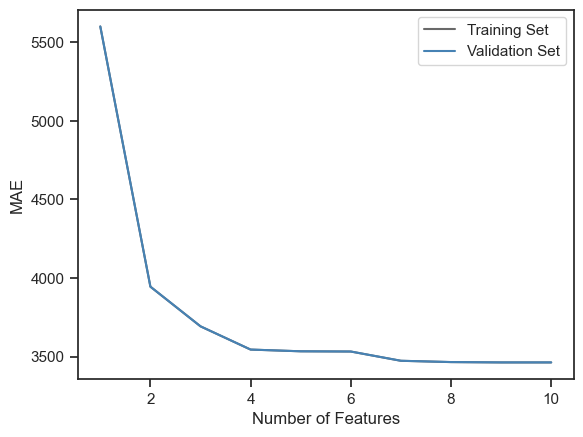

In [83]:
Max_features = X_encoded.shape[1] + 1
train_score_list = [value[0] for value in dic_train_score_rfm_LR.values()]
val_score_list = [value[0] for value in dic_val_score_rfm_LR.values()]

plt.plot(list(range(1, Max_features)), train_score_list, label="Training Set", color='dimgray')
plt.plot(list(range(1, Max_features)), val_score_list, label="Validation Set", color='steelblue')
plt.xlabel("Number of Features")
plt.ylabel("MAE")
plt.legend()
plt.show()

After reviewing the results, we observe the following:
+ **Overfitting:** None of the models exhibited overfitting.
+ **Optimal MAE:** The model with the lowest validation MAE is the one with 9 features (3462.73$).
+ **Trade-off:** However, the model with 7 features achieved similar results (3473.16$), with the mean MAE only higher by approximately 10$. Given the similarity in performance with fewer features, we will now analyze the variables selected in both scenarios.

To proceed, we will perform a simple hold-out split (80% for training and 20% for validation), ensuring the data is shuffled, scaled, and imputed using the optimal hyperparameters previously found. We will then examine and analyze the specific features selected by RFE in both scenarios (Linear Regression with 7 features and 9 features).

In [60]:
X_train_encoded_HO, X_val_encoded_HO, y_train_HO, y_val_HO = train_test_split(X_encoded, Y, 
                                                                              test_size = 0.2, 
                                                                              random_state = 22,
                                                                              shuffle = True)

In [61]:
scaler_HO = RobustScaler()
X_train_encoded_scaled_HO = scaler_HO.fit_transform(X_train_encoded_HO)
X_val_encoded_scaled_HO = scaler_HO.transform(X_val_encoded_HO)

inputer_HO = KNNImputer(n_neighbors= 10, weights='uniform')

X_train_encoded_scaled_imputed_HO = inputer_HO.fit_transform(X_train_encoded_scaled_HO)
X_val_encoded_scaled_imputed_HO = inputer_HO.transform(X_val_encoded_scaled_HO)

X_train_encoded_scaled_imputed_HO = pd.DataFrame(X_train_encoded_scaled_imputed_HO, columns=X_train_encoded_HO.columns)
X_val_encoded_scaled_imputed_HO = pd.DataFrame(X_val_encoded_scaled_imputed_HO, columns=X_val_encoded_HO.columns)

In [77]:
model_LR = LinearRegression()
best_n_rfm_LR = 9
rfe_LR = RFE(estimator = model_LR, n_features_to_select = best_n_rfm_LR)
rfe_LR = rfe_LR.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_LR.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_LR = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_LR.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_LR = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_LR = pd.Series(rfe_LR.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_LR} features. Train:{train_mae_score_LR}, Validation:{val_mae_score_LR}" )
selected_features_LR

Score with 9 features. Train:3468.6625003494228, Validation:3464.4053802931157


mileage                    True
tax                        True
mpg                        True
engineSize                 True
previousOwners            False
Years_old                  True
transmission_manual        True
transmission_semi-auto     True
fuelType_other             True
fuelType_petrol            True
dtype: bool

We see that, when using 9 features, the feature with the lowest importance was: **previousOwners.** 

We are going to decide on which features to use at the end, after we have also run also the Lasso Regression.

In [104]:
model_LR = LinearRegression()
best_n_rfm_LR = 7
rfe_LR = RFE(estimator = model_LR, n_features_to_select = best_n_rfm_LR)
rfe_LR = rfe_LR.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_LR.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_LR = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_LR.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_LR = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_LR = pd.Series(rfe_LR.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_LR} features. Train:{train_mae_score_LR}, Validation:{val_mae_score_LR}" )
selected_features_LR

Score with 7 features. Train:3479.6204279847348, Validation:3474.926730253548


mileage                    True
tax                       False
mpg                        True
engineSize                 True
previousOwners            False
Years_old                  True
transmission_manual        True
transmission_semi-auto     True
fuelType_other             True
fuelType_petrol           False
dtype: bool

We see that, when using 7 features, the features with the lowest importance were: **tax, previousOwners, and fuelType_petrol.**

Now, let's run Recursive Feature Elimination (RFE) using a Decision Tree as the base model on a Hold-Out (HO) set and examine the results. We will use the HO method because running full Cross-Validation (CV) for this base model would be too time-consuming.

In [87]:
# Create dictionaries to save the scores
dic_train_score_rfm_DT = {}
dic_val_score_rfm_DT = {}

# Test every possible number of features
for n in tqdm(range(1, X_encoded.shape[1] + 1)):
    model = DecisionTreeRegressor(criterion='absolute_error', max_depth=11, min_samples_split=500)
    rfe = RFE(model, n_features_to_select=n)

    modelfit_rfm_DT = rfe.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)
    pred_train_rfm_DT = modelfit_rfm_DT.predict(X_train_encoded_scaled_imputed_HO)
    pred_test_rfm_DT = modelfit_rfm_DT.predict(X_val_encoded_scaled_imputed_HO)
    dic_train_score_rfm_DT[n] = mean_absolute_error(y_train_HO, pred_train_rfm_DT)
    dic_val_score_rfm_DT[n] = mean_absolute_error(y_val_HO, pred_test_rfm_DT)

100%|██████████| 10/10 [1:23:24<00:00, 500.42s/it]


In [95]:
dic_train_score_rfm_DT

{1: 5436.882786151834,
 2: 4203.5889255970815,
 3: 2820.91885195127,
 4: 2532.888120311102,
 5: 2491.8392697363893,
 6: 2484.531557574506,
 7: 2479.5658854704384,
 8: 2479.48867781678,
 9: 2479.48867781678,
 10: 2479.48867781678}

In [96]:
dic_val_score_rfm_DT

{1: 5376.354532314681,
 2: 4157.2561084727095,
 3: 2864.8533278271043,
 4: 2578.700048179503,
 5: 2563.048592470232,
 6: 2557.110468717737,
 7: 2554.556301190722,
 8: 2553.1622616835293,
 9: 2553.1622616835293,
 10: 2553.1622616835293}

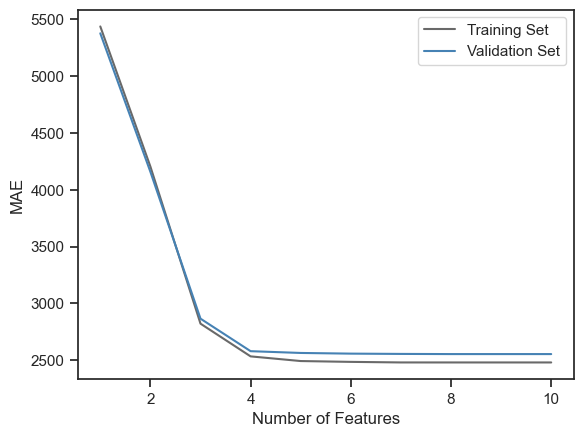

In [94]:
Max_features = X_encoded.shape[1] + 1

plt.plot(list(range(1, Max_features)), dic_train_score_rfm_DT.values(), label="Training Set", color='dimgray')
plt.plot(list(range(1, Max_features)), dic_val_score_rfm_DT.values(), label="Validation Set", color='steelblue')
plt.xlabel("Number of Features")
plt.ylabel("MAE")
plt.legend()
plt.show()

After reviewing the results, we observe the following:
+ **Overfitting:** The model starts to overfit after retaining 4 features, showing no substantial improvement in the Mean Absolute Error (MAE) scores for either the training or validation sets beyond this point.
+ **Optimal MAE:** The model with the lowest validation MAE is the one with 8 features (2553.16$). Since the results are practically the same for 8, 9, and 10 features, we should choose the solution with the fewest features (8) for simplicity and efficiency.

So, let's examine the features selected in the 4 feature and 8 feature scenarios using Recursive Feature Elimination (RFE) with a Decision Tree (DT) as the base estimator.

In [97]:
model_DT =DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_split=500)
best_n_rfm_DT = 8
rfe_DT = RFE(estimator = model_DT, n_features_to_select = best_n_rfm_DT)
rfe_DT = rfe_DT.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_DT.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_DT = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_DT.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_DT = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_DT = pd.Series(rfe_DT.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_DT} features. Train:{train_mae_score_DT}, Validation:{val_mae_score_DT}" )
selected_features_DT

Score with 8 features. Train:2690.978422465414, Validation:2724.220490054374


mileage                    True
tax                        True
mpg                        True
engineSize                 True
previousOwners             True
Years_old                  True
transmission_manual        True
transmission_semi-auto    False
fuelType_other            False
fuelType_petrol            True
dtype: bool

We see that, when using 8 features, the features with the lowest importance were: **transmission_semi-auto, and fuelType_other.**

In [98]:
model_DT =DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_split=500)
best_n_rfm_DT = 4
rfe_DT = RFE(estimator = model_DT, n_features_to_select = best_n_rfm_DT)
rfe_DT = rfe_DT.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)

y_pred_train= rfe_DT.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_DT = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= rfe_DT.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_DT = mean_absolute_error(y_val_HO, y_pred_val)

selected_features_DT = pd.Series(rfe_DT.support_, index = X_train_encoded_scaled_imputed_HO.columns)
print(f"Score with {best_n_rfm_DT} features. Train:{train_mae_score_DT}, Validation:{val_mae_score_DT}" )
selected_features_DT

Score with 4 features. Train:2738.085157271664, Validation:2763.3148874664466


mileage                   False
tax                       False
mpg                        True
engineSize                 True
previousOwners            False
Years_old                  True
transmission_manual        True
transmission_semi-auto    False
fuelType_other            False
fuelType_petrol           False
dtype: bool

We see that, when using 8 features, the features with the lowest importance were: **mileage, tax, previousOwners, transmission_semi-auto, fuelType_other and fuelType_petrol.**

Let's save the results into a DataFrame and then export it to a CSV file , so we don't need to rerun the analysis.

In [109]:
df_features_experiments_rfe = []

for k in dic_train_score_rfm_LR.keys():
    # Extract values
    train_lr_mae, train_lr_var = dic_train_score_rfm_LR[k]
    val_lr_mae, val_lr_var = dic_val_score_rfm_LR[k]
    train_dt_mae = dic_train_score_rfm_DT[k]
    val_dt_mae = dic_val_score_rfm_DT[k]
    
    # Append row
    df_features_experiments_rfe.append({
        'n_features': k,
        'MAE_train_LR': train_lr_mae,
        'var_train_LR': train_lr_var,
        'MAE_val_LR': val_lr_mae,
        'var_val_LR': val_lr_var,
        'MAE_train_DT': train_dt_mae,
        'MAE_val_DT': val_dt_mae
    })

# Create DataFrame
df_features_experiments_rfe = pd.DataFrame(df_features_experiments_rfe).set_index('n_features')
df_features_experiments_rfe

,MAE_train_LR,var_train_LR,MAE_val_LR,var_val_LR,MAE_train_DT,MAE_val_DT
n_features,,,,,,
1,5599.96,8.79,5600.14,28.24,5436.882786,5376.354532
2,3944.50,7.12,3944.56,20.66,4203.588926,4157.256108
3,3692.11,4.35,3692.37,15.68,2820.918852,2864.853328
4,3544.26,4.94,3544.43,21.78,2532.888120,2578.700048
5,3533.31,5.12,3533.42,21.40,2491.839270,2563.048592
6,3531.88,5.14,3531.98,21.24,2484.531558,2557.110469
7,3472.95,6.80,3473.16,20.17,2479.565885,2554.556301
8,3464.65,6.79,3464.95,20.84,2479.488678,2553.162262
9,3462.43,6.85,3462.73,20.56,2479.488678,2553.162262


In [ ]:
df_features_experiments_rfe.to_csv('../project_data/rfe_experiments.csv', index=False)

#### <a id='toc6_1_3_2_'></a>[Decision Tree Feature Importance](#toc0_)

Now, we will analyze the feature importance using a Decision Tree to see the proportion in which each of the variables contributes to the output.

In [34]:
dt_model_feature_importance = DecisionTreeRegressor(
    criterion='absolute_error',
    max_depth=11,
    min_samples_split=500,
    random_state=22
)

dt_model_feature_importance.fit(X_train_encoded_scaled_imputed_HO, y_train_HO)
importances = dt_model_feature_importance.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_encoded_scaled_imputed_HO.columns,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

y_pred_train= dt_model_feature_importance.predict(X_train_encoded_scaled_imputed_HO)
train_mae_score_DT = mean_absolute_error(y_train_HO, y_pred_train)
y_pred_val= dt_model_feature_importance.predict(X_val_encoded_scaled_imputed_HO)
val_mae_score_DT = mean_absolute_error(y_val_HO, y_pred_val)

print(f"MAE Score -> Train:{train_mae_score_DT}, Validation:{val_mae_score_DT}" )

MAE Score -> Train:2483.0157959942185, Validation:2551.2010117695645


First of all, the model does not achieve overfitting. This means the model is not memorizing the training data, so we can trust the feature importance results, to some extent.

In [38]:
importance_df

,Feature,Importance
5,Years_old,0.319847
6,transmission_manual,0.292340
3,engineSize,0.266574
2,mpg,0.069304
0,mileage,0.044743
1,tax,0.003902
9,fuelType_petrol,0.003073
7,transmission_semi-auto,0.000217
4,previousOwners,0.000000
8,fuelType_other,0.000000


Let's plot these feature importances.

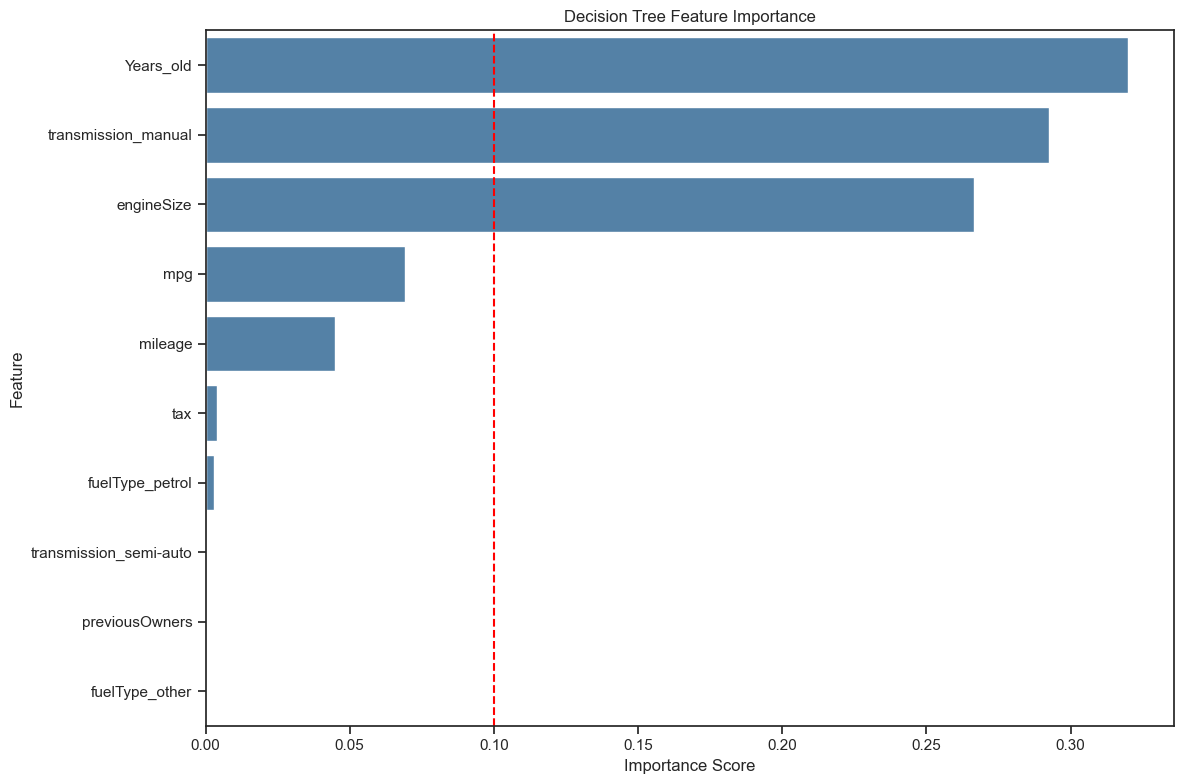

In [35]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df, 
    x='Importance', 
    y='Feature', 
    color='steelblue')

plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')

plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Let's start by noting that if all features contributed equally to the total error reduction (predictive improvement), all should have an importance of 0.1 (or 10%, since there are 10 features, 1/10 = 0.1). This is clearly not what we observe.

We see that only the **Years_old, transmission_manual, and engineSize features contributed more than 10%** to the improvement in MAE of the model.

**The rest of the features contributed less than 10%**, leading us to conclude that they could be considered less important (or not important at all). This lower-importance group includes:
+ Features contributing **less than 10% (but more than 1%)**: mpg, mileage.
+ Features contributing **less than 1%**: tax, fuelType_petrol, transmission_semi-auto.
+ Features **contributing 0%**: previousOwners and fuelType_other.

#### <a id='toc6_1_3_3_'></a>[Lasso](#toc0_)

We will also use Lasso Regression to perform feature selection (using a Hold-Out (HO) method). By analyzing the coefficients assigned by Lasso, we can identify the features that have the most impact on the target variable. This will help us determine which features to retain for our final models.

To do so, we are going to test different values for the alpha (penalization coefficient) of the Lasso Regression using the following set: 0 (which is equivalent to Linear Regression), 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, and 1.

In [99]:
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
results = {}

for a in tqdm(alphas):
    model_lasso = Lasso(alpha=a, random_state=22).fit(X_train_encoded_scaled_imputed_HO, y_train_HO)
    train_mae = mean_absolute_error(y_train_HO, model_lasso.predict(X_train_encoded_scaled_imputed_HO))
    val_mae = mean_absolute_error(y_val_HO, model_lasso.predict(X_val_encoded_scaled_imputed_HO))
    # Combine Coefs and Scores into one list
    results[f'Alpha_{a}'] = [train_mae, val_mae] + list(model_lasso.coef_)

# Create DF: Index is Features + Names of the error metrics
idx = ['TRAIN_MAE', 'VAL_MAE'] + list(X_train_encoded_scaled_imputed_HO.columns)
lasso_df = pd.DataFrame(results, index=idx)

lasso_df

100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


,Alpha_0,Alpha_0.001,Alpha_0.005,Alpha_0.01,Alpha_0.05,Alpha_0.1,Alpha_0.5,Alpha_1
TRAIN_MAE,3468.586392,3468.586252,3468.585692,3468.584992,3468.579261,3468.572038,3468.514759,3468.445836
VAL_MAE,3464.762827,3464.762679,3464.762085,3464.761339,3464.755234,3464.747524,3464.686109,3464.609130
mileage,-2340.473694,-2340.474517,-2340.477704,-2340.481478,-2340.512924,-2340.552846,-2340.881436,-2341.304369
tax,-54.796044,-54.795412,-54.792910,-54.789863,-54.765130,-54.734260,-54.485621,-54.174397
mpg,-725.946108,-725.943512,-725.933086,-725.920047,-725.819078,-725.694830,-724.707196,-723.486104
engineSize,7889.368811,7889.364395,7889.346990,7889.326050,7889.150664,7888.929545,7887.137061,7884.877973
previousOwners,41.763293,41.761256,41.753109,41.742923,41.661437,41.559575,40.744701,39.726097
Years_old,-4378.304490,-4378.302584,-4378.295091,-4378.286084,-4378.211958,-4378.118835,-4377.362487,-4376.406263
transmission_manual,-3288.645841,-3288.649498,-3288.663885,-3288.680853,-3288.819975,-3288.992327,-3290.387707,-3292.127336
transmission_semi-auto,1024.134430,1024.126341,1024.094095,1024.054243,1023.734069,1023.334558,1020.130726,1016.127218


After reviewing the results, we can draw some interesting conclusions:
+ **Overfitting:** The model generally maintains no overfitting across the different alpha values tested, and it also maintains stable MAE values.
+ **Coefficient Magnitude:** There are variables with consistently higher coefficients than others. If we sort by the absolute value of the coefficient, we observe the following order of importance: engineSize, Years_old, transmission_manual, mileage, fuelType_other, transmission_semi-auto, mpg, fuelType_petrol, tax, previousOwners.
+ **Stability:** Despite the clear difference in coefficient magnitudes, the different values for the penalization alphas do not change any of the coefficients by a large magnitude. This means all of the variables contribute in some unique way to the model.

The conclusion of the Lasso analysis is that **all variables should be kept** since they add (even in a small proportion) some non-redundant information to our model.

#### <a id='toc6_1_3_4_'></a>[Conclusion Feature Selection](#toc0_)

Now, we are going to discard all the variables that were recommended to be discarded by 3 or more methods. We chose this threshold (3) because we tested 6 methods in total, and if a feature was deemed not relevant in half (or more) of the approaches, we will remove it.

| Feature Name | RFE LR (n=9) | RFE LR (n=7) | RFE DT (n=8) | RFE DT (n=4) | DT Feature Importance | Lasso | Final Decision |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **mileage** | Keep | Keep | Keep | Discard | Discard? | Keep | ✅ |
| **tax** | Keep | Discard | Keep | Discard | Discard | Keep | ❌ |
| **mpg** | Keep | Keep | Keep | Keep | Discard? | Keep | ✅ |
| **engineSize** | Keep | Keep | Keep | Keep | Keep | Keep | ✅ |
| **previousOwners** | Discard | Discard | Keep | Discard | Discard | Keep | ❌ |
| **Years_old** | Keep | Keep | Keep | Keep | Keep | Keep | ✅ |
| **transmission_manual** | Keep | Keep | Keep | Keep | Keep | Keep | ✅ |
| **transmission_semi-auto** | Keep | Keep | (Keep because of pair) | (Keep because of pair) | (Keep because of pair) | Keep | ✅ |
| **fuelType_other** | Keep | Keep | (Keep because of pair) | Discard | Discard | Keep | ❌ |
| **fuelType_petrol** | Keep | (Keep because of pair) | Keep | Discard | Discard | Keep | ❌ |


So, from now on, the only features that **we are going to use are: mileage, mpg, engineSize, Years_old$, transmission_manual, and transmission_semi-auto**. The transmission_semi-auto feature was kept because its pair, the transmission_manual category, was consistently relevant across all methods tested.

## <a id='toc6_2_'></a>[Experimenting with Logarithms](#toc0_)

We saw during the data exploration phase that the target variable (price) and the features (Years_old and mileage) were heavily skewed. For that reason, now that we have determined the best scaler, imputer, and set of features to use, we will test applying a logarithmic transformation to these variables and evaluate the results to see what works best overall.

Since we are going to apply a logarithmic transformation, we need to first revert the data's scale back to its original values (or units).

In [ ]:
# inverse scale to original units (scalar already applied earlier)
X_train_orig= pd.DataFrame(scaler_HO.inverse_transform(X_train_encoded_scaled_imputed_HO),
                                columns=X_train_encoded_scaled_imputed_HO.columns, index=X_train_encoded_scaled_imputed_HO.index)
X_val_orig = pd.DataFrame(scaler_HO.inverse_transform(X_val_encoded_scaled_imputed_HO),
                              columns=X_val_encoded_scaled_imputed_HO.columns, index=X_val_encoded_scaled_imputed_HO.index)

# Select only relevant features
X_train_orig.drop(columns=['tax','previousOwners', 'fuelType_other','fuelType_petrol'], inplace=True)
X_val_orig.drop(columns=['tax','previousOwners', 'fuelType_other','fuelType_petrol'], inplace=True)

We will now define the four different scenarios to test. The primary goal is to establish a performance benchmark using the original scale for all variables (mileage, Years_old, and target). Beyond this baseline, we will test three transformations: 
+ One scenario applying the log transformation only to the mileage and Years_old features, 
+ A second scenario applying the log transformation to both the features and the target, and,
+ A final scenario where only the target variable is log transformed.
 
To test our solutions, we are going to use the 3 models we have been working with until now (Linear Regression (LR), Decision Tree (DT), and K-Nearest Neighbors (KNN)) and see if a general trend exists.

In [67]:
# Scenario definitions
scenarios = [
    {
        'name': 'A_all_features_normal__price_orig',
        'feature_log_cols': [],
        'target_log': False
    },
    {
        'name': 'B_mileage_years_log__price_orig',
        'feature_log_cols': ['mileage', 'Years_old'],
        'target_log': False
    },
    {
        'name': 'C_all_features_normal__price_log',
        'feature_log_cols': [],
        'target_log': True
    },
    {
        'name': 'D_mileage_years_log__price_log',
        'feature_log_cols': ['mileage', 'Years_old'],
        'target_log': True
    }
]

models = [
    ('LinearRegression', LinearRegression()),
    ('DecisionTree', DecisionTreeRegressor(criterion='absolute_error', max_depth=11, min_samples_split=500, random_state=22)),
    ('KNN', KNeighborsRegressor(n_neighbors=8, weights='uniform', n_jobs=-1))
]

Now we will run each of the scenarios, transform depending on that and at the end, evaluate the MAE for the train and validation, saving it into a dataframe.

In [69]:
results = []

for scen in tqdm(scenarios):
    # copy original-unit data and drop Brand
    Xtr = X_train_orig.copy()
    Xva = X_val_orig.copy()

    # Apply feature transforms (log1p) where requested
    feat_log_cols = [c for c in scen['feature_log_cols'] if c in Xtr.columns]
    if feat_log_cols:
        Xtr[feat_log_cols] = np.log1p(Xtr[feat_log_cols].clip(lower=0))
        Xva[feat_log_cols] = np.log1p(Xva[feat_log_cols].clip(lower=0))

    # Prepare target
    if scen['target_log']:
        ytr_train_trans = np.log1p(y_train_HO)
        yva_val_trans = np.log1p(y_val_HO)
        y_train_used_for_fit = ytr_train_trans
        y_val_used_for_fit = yva_val_trans
    else:
        y_train_used_for_fit = y_train_HO
        y_val_used_for_fit = y_val_HO

    # Scale features before fitting models (fit scaler on training features)
    scaler_feat = RobustScaler()
    Xtr_scaled = scaler_feat.fit_transform(Xtr)
    Xva_scaled = scaler_feat.transform(Xva)

    # store the transformation info
    diag = {
        'scenario': scen['name'],
        'y_transform': 'log1p' if scen['target_log'] else 'none'
    }

    # Test each of the model on the transformation
    for name, model in models:
        # fit
        model_fit = model.fit(Xtr_scaled, y_train_used_for_fit)

        # predict (on transformed target space if applied)
        ytr_pred_t = model_fit.predict(Xtr_scaled)
        yva_pred_t = model_fit.predict(Xva_scaled)

        # convert predictions back to original price scale for MAE comparability
        if scen['target_log']:
            ytr_pred_orig = np.expm1(ytr_pred_t)
            yva_pred_orig = np.expm1(yva_pred_t)
            ytr_true_orig = y_train_HO
            yva_true_orig = y_val_HO
        else:
            ytr_pred_orig = ytr_pred_t
            yva_pred_orig = yva_pred_t
            ytr_true_orig = y_train_HO
            yva_true_orig = y_val_HO

        mae_train = mean_absolute_error(ytr_true_orig, ytr_pred_orig)
        mae_val = mean_absolute_error(yva_true_orig, yva_pred_orig)

        # store results
        row = diag.copy()
        row.update({
            'model': name,
            'MAE_train': mae_train,
            'MAE_val': mae_val
        })
        results.append(row)

# results dataframe
df_results_transform = pd.DataFrame(results).sort_values(['scenario','model']).reset_index(drop=True)    

100%|██████████| 4/4 [04:43<00:00, 70.99s/it]


Now, let's analyze the results.

In [70]:
df_results_transform

,scenario,y_transform,model,MAE_train,MAE_val
0,A_all_features_normal__price_orig,none,DecisionTree,2494.522696,2559.536616
1,A_all_features_normal__price_orig,none,KNN,2005.829167,2296.410042
2,A_all_features_normal__price_orig,none,LinearRegression,3483.171192,3478.261282
3,B_mileage_years_log__price_orig,none,DecisionTree,2494.522696,2559.536616
4,B_mileage_years_log__price_orig,none,KNN,2062.962168,2366.973381
5,B_mileage_years_log__price_orig,none,LinearRegression,3358.667052,3387.943473
6,C_all_features_normal__price_log,log1p,DecisionTree,2500.713212,2568.590268
7,C_all_features_normal__price_log,log1p,KNN,1998.286241,2276.214021
8,C_all_features_normal__price_log,log1p,LinearRegression,3031.204138,3020.501116
9,D_mileage_years_log__price_log,log1p,DecisionTree,2500.713212,2568.590268


On a specific level, the conclusion is the following: 
+ Applying these transformations created some difference in the scores between the training and validation sets for all of the models, meaning the transformations affected model performance.

Now, let's analyze each of the scenarios individually.

In [71]:
df_results_transform.groupby('scenario')[['MAE_train', 'MAE_val']].mean()

,MAE_train,MAE_val
scenario,,
A_all_features_normal__price_orig,2661.174352,2778.069313
B_mileage_years_log__price_orig,2638.717306,2771.484490
C_all_features_normal__price_log,2510.067864,2621.768468
D_mileage_years_log__price_log,2582.358060,2702.216589


In comparison to one another, the conclusions are:

+ The base scenario (no transformations) is the one with the worst results and the most overfitting.
+ Next, when we apply a logarithmic transformation to the independent features, the overfitting is reduced, but no improvement in the validation score is achieved.
+ When we apply a logarithmic transformation to both the dependent and independent features, the validation score improves but still exhibits some overfitting.
+ The best option across all scenarios is when we only apply the transformation to the target variable. This scenario yields the least overfitting and the best performance on the validation MAE.

So, let's analyze the transformation on the target variable exclusively to see if that conclusion is truly accurate and stable.

In [72]:
df_results_transform.groupby('y_transform')[['MAE_train', 'MAE_val']].mean()

,MAE_train,MAE_val
y_transform,,
log1p,2546.212962,2661.992529
none,2649.945829,2774.776902


To conclude, as we saw, applying a logarithmic transformation to the target feature leads to the best results. Therefore, from the modeling part onward, **we are going to only transform the price variable for the target.** When we calculate the Mean Absolute Error (MAE), we just need to take into consideration returning the variable to its original scale (performing the exponential function) to have interpretable results.

## <a id='toc6_3_'></a>[Conclusion Data Preparation](#toc0_)

We will now prepare the dataset for the modeling phase, incorporating all findings until now. We will create three distinct datasets tailored for optimization, final training, and evaluation:

1. **Modeling Score Set:** Will be compoused by the training data with inconsistencies solved and featuring only the selected variables, which have been encoded. This set is ready to be used when applying Cross-Validation (CV).

2. **Final Best Model Sets**
    + **Full Training Set:** Entire Training Dataset with inconsistencies solved, featuring only the selected variables, and having been encoded, scaled, and imputed. To be used on the training the final production model (if does not need a validation set).

    + **Hold-Out Evaluation Sets (Train & Validation):** Training and Validation Data with inconsistencies solved, featuring only the selected variables, and having been encoded, scaled, and imputed. The scaler and imputer must be fit exclusively on the training set and then transformed onto both the training and validation sets. To be used on the training the final production model if it needs a validation set. Or used in case of implementing HO aproach.

**Note:** The target variable will be exported in the logarithmic scale, and it will be necessary to revert this transformation (on both the actual target values and the model's predictions) when we want to calculate the Mean Absolute Error (MAE). This ensures the MAE is calculated on the original, interpretable scale.

Finally, we will also perform some data visualization and verification. We will analyze and visualize the full dataset after it has been scaled and imputed. We will then inverse the scaling on the data to see the true distribution of the variables after the imputation process.

### <a id='toc6_3_1_'></a>[Modeling Optimization Set](#toc0_)

Will be compoused by the training data with inconsistencies solved and featuring only the selected variables, which have been encoded. This set is ready to be used when applying Cross-Validation (CV).

In [87]:
# importing a clean version of the  train data
df_cars4you_train_modeling = pd.read_csv('../project_data/train.csv')

Select only the relevant columns (we are going to maintain the brand in case we want to test different models by brand).

In [88]:
df_cars4you_train_modeling.set_index('carID', inplace=True)

df_cars4you_train_modeling.drop(['model',
                                 'tax',
                                 'previousOwners',
                                 'fuelType',
                                 'paintQuality%',
                                 'hasDamage'], inplace=True, axis=1)

df_cars4you_train_modeling.dropna(subset=['Brand'], inplace = True)

Now, we will fix the inconsistencies within the categorical variables.

In [89]:
# Remove spaces and convert to lower case 
df_cars4you_train_modeling = df_cars4you_train_modeling.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)

dict_brand_mapping = {'bmw' : ['bm','mw', 'm'],
                      'vw': ['v', 'w'],
                      'toyota': ['toyot', 'oyota', 'oyot'],
                      'audi': ['udi', 'aud', 'ud'],
                      'ford': ['ord', 'for', 'or'],
                      'skoda': ['koda', 'skod', 'kod'],
                      'opel': ['ope','pel','pe'],
                      'mercedes': ['mercede', 'ercedes', 'ercede'],
                      'hyundai': ['yundai', 'hyunda', 'yunda']}

dict_transmission_mapping = {'semi-auto':['semi-aut','emi-auto','emi-aut'],
                      'manual': ['anual','manua','anua'],
                      'NAN' : ['unknown', 'unknow', 'nknown', 'nknow', 'other'],
                      'automatic': ['automati','utomati','utomatic']}

# Map categorical values
for key, values in dict_brand_mapping.items():
    df_cars4you_train_modeling.loc[df_cars4you_train_modeling['Brand'].isin(values), 'Brand'] = key
    
for key, values in dict_transmission_mapping.items():
    df_cars4you_train_modeling.loc[df_cars4you_train_modeling['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan

Now, we will fix the inconsistencies related to negative values and 'impossible' values in the numerical columns.

In [90]:
df_cars4you_train_modeling['mileage'] = pd.to_numeric(df_cars4you_train_modeling['mileage'], errors='coerce').abs()
df_cars4you_train_modeling['mpg'] = pd.to_numeric(df_cars4you_train_modeling['mpg'], errors='coerce').abs()
df_cars4you_train_modeling['engineSize'] = pd.to_numeric(df_cars4you_train_modeling['engineSize'], errors='coerce').abs()
df_cars4you_train_modeling.loc[df_cars4you_train_modeling['engineSize'] < 0.9, 'engineSize'] = 0.9
df_cars4you_train_modeling['year'] = df_cars4you_train_modeling['year'].round().astype('Int64')
df_cars4you_train_modeling = df_cars4you_train_modeling[~(df_cars4you_train_modeling['year'] > 2020)]

Now, we will impute the categorical variables that have missing values using the mode.

In [91]:
mode_to_fill_transmission = df_cars4you_train_modeling['transmission'].mode()[0]

df_cars4you_train_modeling['transmission'].fillna(mode_to_fill_transmission, inplace=True)

Finally, we will perform the feature engineering part.

In [92]:
df_cars4you_train_modeling['Years_old'] = 2021 - df_cars4you_train_modeling['year']
df_cars4you_train_modeling.drop('year', inplace = True, axis = 1)

# Dummies for categorical variables
df_cars4you_train_modeling = pd.get_dummies(df_cars4you_train_modeling, columns=['transmission'], drop_first=True, dtype= int)

This data is now ready to be saved and used for model optimization, so we will proceed with saving it.

In [93]:
X_ModelOptimization = df_cars4you_train_modeling.drop('price', axis=1)
y_Modeling = np.log(df_cars4you_train_modeling['price'])

columns_names_train = X_ModelOptimization.columns

pd.to_pickle((X_ModelOptimization, y_Modeling), '../project_data/X_Ylog_ModelOptimization.pkl')

We will also save the dictionary of inconsistencies found, the mode used to fill categorical variables, and the final list of dummy columns created.

In [94]:
pd.to_pickle((dict_brand_mapping,
              dict_transmission_mapping, 
              mode_to_fill_transmission,
              columns_names_train), '../project_data/DicBrand_DicTrans_ModeTrans_ColNames_PrePro.pkl')

### <a id='toc6_3_2_'></a>[Full Training Set](#toc0_)

We are going to continue with the X_ModelOptimization dataset and perform the scaling and imputation steps.

In [95]:
scaler = RobustScaler()
X_full = scaler.fit_transform(X_ModelOptimization.drop('Brand', axis=1))

inputer = KNNImputer(n_neighbors= 10, weights='uniform')
X_full = inputer.fit_transform(X_full)

X_full = pd.DataFrame(X_full, columns=X_ModelOptimization.drop('Brand', axis=1).columns)
X_full['Brand'] = X_ModelOptimization['Brand'].values

And save it.

In [96]:
pd.to_pickle((X_full, y_Modeling, scaler, inputer), '../project_data/X_Ylog_Scale_Impute_ModelFull.pkl')

### <a id='toc6_3_3_'></a>[Hold-Out Train and Validation Sets](#toc0_)

We are going to continue with the X_ModelOptimization and y_Modeling dataset and perform the scaling and imputation steps, using the HO method.

In [97]:
X_train_HO, X_val_HO, y_train_HO, y_val_HO = train_test_split(X_ModelOptimization, 
                                                              y_Modeling, 
                                                              test_size = 0.2, 
                                                              random_state = 22,
                                                              shuffle = True)

In [98]:
train_brands = X_train_HO['Brand'].values
val_brands = X_val_HO['Brand'].values

scaler_HO = RobustScaler()
X_train_HO = scaler_HO.fit_transform(X_train_HO.drop('Brand', axis=1))
X_val_HO = scaler_HO.transform(X_val_HO.drop('Brand', axis=1))

inputer_HO = KNNImputer(n_neighbors= 10, weights='uniform')

X_train_HO = inputer_HO.fit_transform(X_train_HO)
X_val_HO = inputer_HO.transform(X_val_HO)

X_train_HO = pd.DataFrame(X_train_HO, columns=X_ModelOptimization.drop('Brand', axis=1).columns)
X_val_HO = pd.DataFrame(X_val_HO, columns=X_ModelOptimization.drop('Brand', axis=1).columns)

X_train_HO['Brand'] = train_brands
X_val_HO['Brand'] = val_brands

And save it.

In [99]:
pd.to_pickle((X_train_HO, X_val_HO, y_train_HO, y_val_HO, scaler_HO, inputer_HO), '../project_data/Train_Val_Yslog_Scalar_Imputer_ModelHO.pkl')

### <a id='toc6_3_4_'></a>[Visualizations on Preprocessed Data](#toc0_)

Let's finally visualize the transformations that were made.

In [100]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72645 entries, 0 to 72644
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mileage                 72645 non-null  float64
 1   mpg                     72645 non-null  float64
 2   engineSize              72645 non-null  float64
 3   Years_old               72645 non-null  float64
 4   transmission_manual     72645 non-null  float64
 5   transmission_semi-auto  72645 non-null  float64
 6   Brand                   72645 non-null  object 
dtypes: float64(6), object(1)
memory usage: 3.9+ MB


First of all, we can confirm that the features have been correctly imputed, as we now have 0 missing values.

Now, let's see the variable distribution of the imputed features after and before scaling.

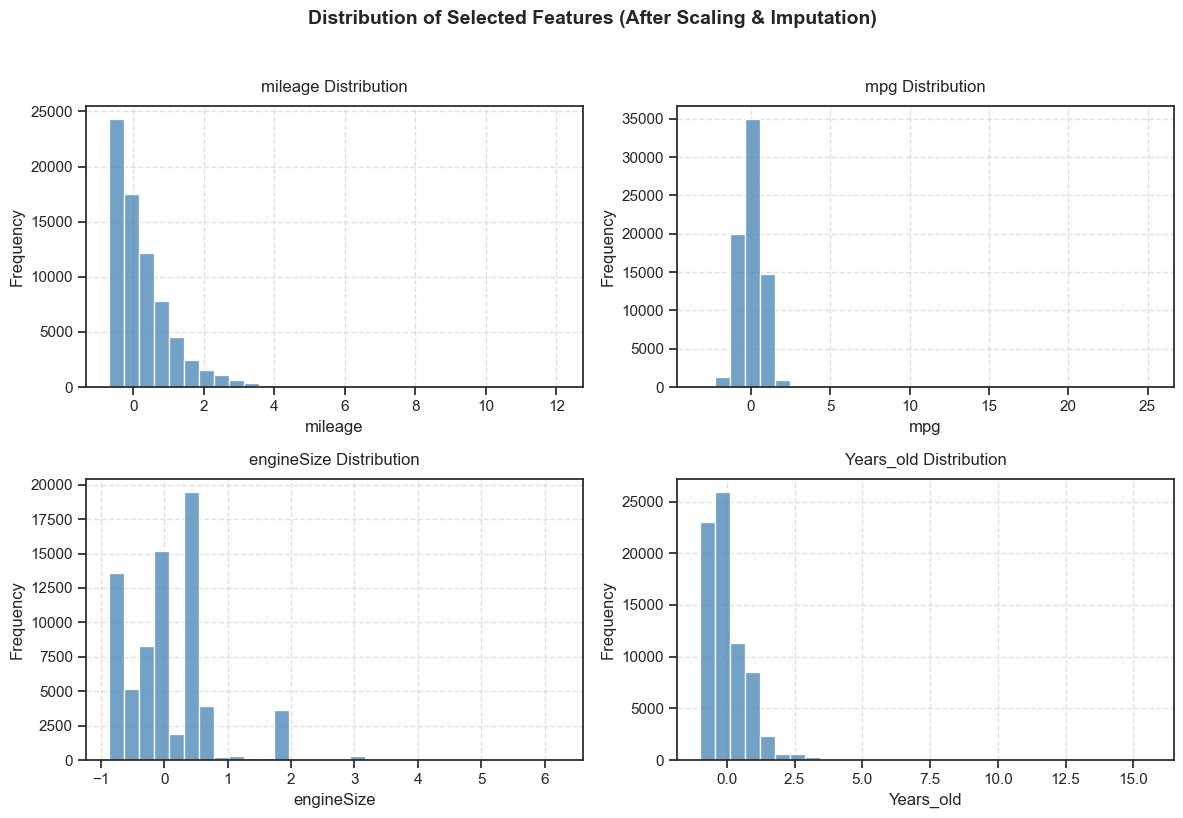

In [101]:
# Select the variables to plot
variables = ['mileage', 'mpg', 'engineSize', 'Years_old']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(variables):
    sns.histplot(X_full[var].dropna(), kde=False, ax=axes[i], bins=30, color="steelblue")
    axes[i].set_xlabel(var)
    axes[i].set_title(f"{var} Distribution", fontsize=12, pad=10)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Distribution of Selected Features (After Scaling & Imputation)", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

We see that the variables were correctly scaled, as the values are now on a similar scale (centered around 0), while still allowing for the existence of some outliers.

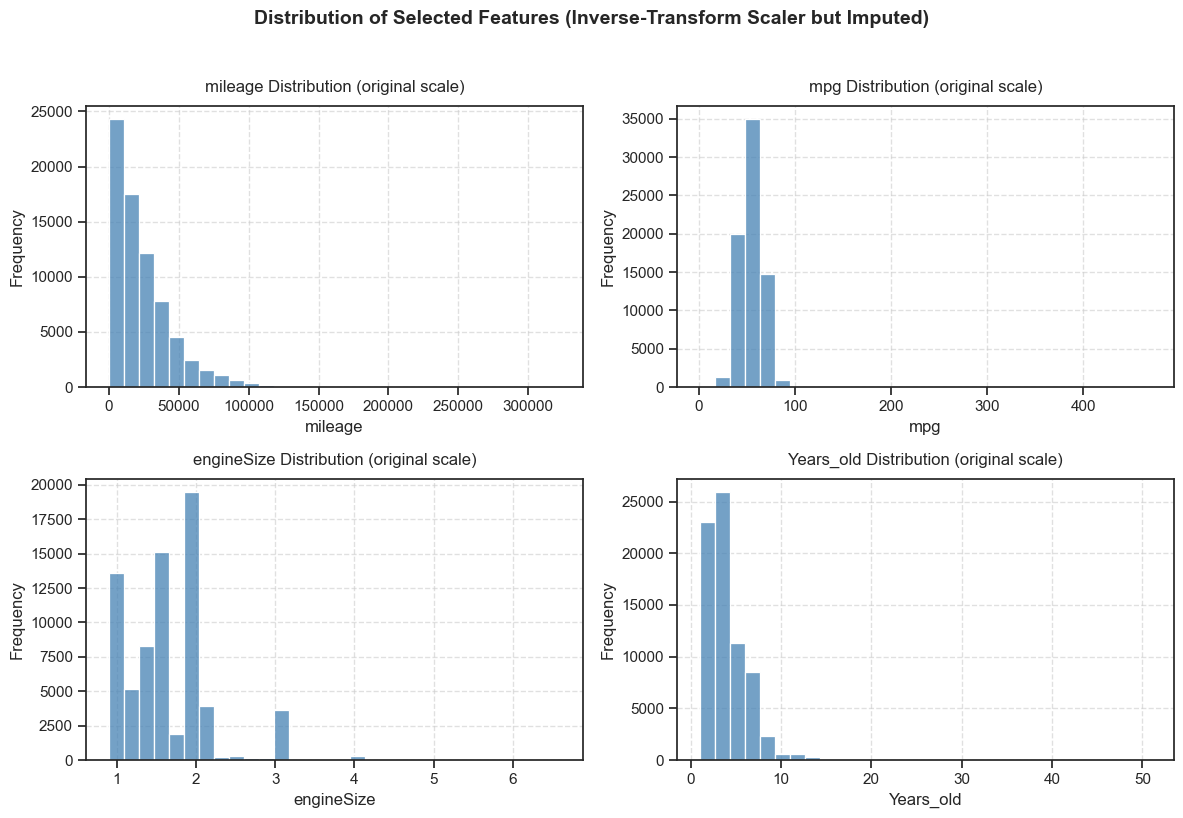

In [102]:
numeric_cols = [c for c in X_full.columns if c != 'Brand']

# inverse transform (scaler was fit on X_ModelOptimization.drop('Brand', axis=1))
X_inv = pd.DataFrame(scaler.inverse_transform(X_full[numeric_cols]), columns=numeric_cols)

variables = ['mileage', 'mpg', 'engineSize', 'Years_old']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(X_inv[var].dropna(), kde=False, ax=axes[i], bins=30, color="steelblue")
    axes[i].set_xlabel(var)
    axes[i].set_title(f"{var} Distribution (original scale)", fontsize=12, pad=10)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Distribution of Selected Features (Inverse-Transform Scaler but Imputed)", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Now, viewing the normal scale (before scaling), we see that the distribution is maintained after imputation, and we still have some presence of outliers in the different variables that were imputed. This was an expected outcome.

Now, let's see our target feature's distribution before and after the logarithmic transformation.

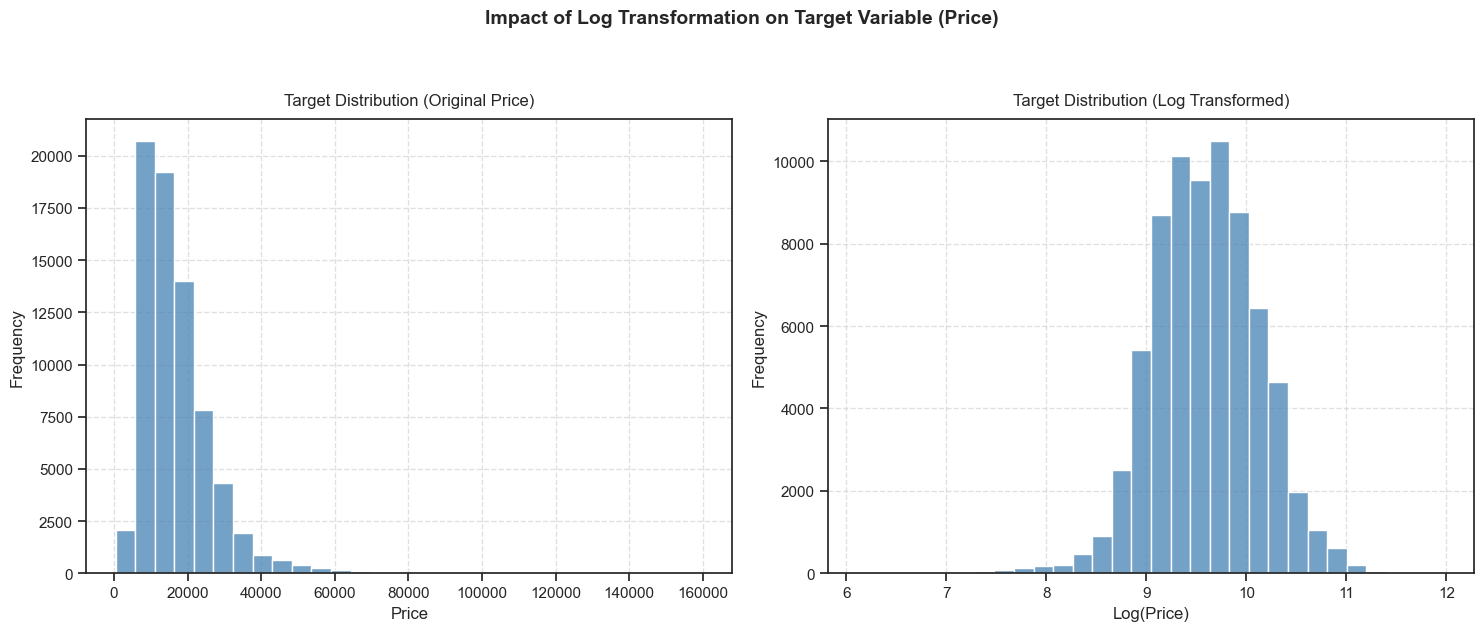

In [109]:
y_original = np.exp(y_Modeling)

# Create the figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Plot 1: Original Price (Left) ---
sns.histplot(y_original, ax=axes[0], bins=30, color="steelblue")
axes[0].set_title("Target Distribution (Original Price)", fontsize=12, pad=10)
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Log-Transformed Price (Right) ---
sns.histplot(y_Modeling, ax=axes[1], bins=30, color="steelblue")
axes[1].set_title("Target Distribution (Log Transformed)", fontsize=12, pad=10)
axes[1].set_xlabel("Log(Price)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Impact of Log Transformation on Target Variable (Price)", fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

We see that, after applying the logarithmic transformation to the price variable, it now exhibits a normal distribution.

Now we can now continue with the modeling phase.